In [1]:
### Loading libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm 
from typing import Union
from statsmodels.tsa.filters.hp_filter import hpfilter
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

import matplotlib.pyplot as plt
import helperfunc
from helperfunc import *

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR 
import shap
from sklearn.inspection import PartialDependenceDisplay
import os

import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
data = pd.read_excel('Quarterly PC.xlsx', sheet_name ="base", index_col="Quarter")
data = data.dropna()
data.tail(13)

,LGDP_SA,Inflation,Crude_YoY,FX_YoY,Rainfall_YoY,GDP_YoY,Spread
Quarter,,,,,,,
2020-03-31,6.557265,6.668254,-18.700400,-1.562423,8.562,2.944924,0.803887
2020-06-30,6.460310,6.571227,-38.251081,-4.609472,7.152,-23.367163,1.295281
2020-09-30,6.532819,6.896552,38.761737,1.976778,105.188,-5.724427,1.121724
2020-12-31,6.555687,6.364859,3.824804,0.871914,2.654,1.587567,1.113754
2021-03-31,6.567764,4.867158,35.871585,1.176359,-23.890,3.373813,1.027781
2021-06-30,6.550545,5.593482,13.073132,-1.144902,57.420,21.550002,0.917244
2021-09-30,6.569811,5.075269,6.858781,-0.484793,-21.600,9.111219,0.823681
2021-12-31,6.577485,4.993679,9.256416,-1.156781,53.900,5.195651,0.423524
2022-03-31,6.583204,6.344475,23.425214,-0.389598,-2.600,3.958153,0.355913


In [3]:
#data["Inflation"] = data["Inflation"].shift(-3)  ## Edit this for Multiperiod ahead forecasts
#data = data.dropna()


In [4]:

def initialize_prediction_matrices(frcst_length):
    """Initialize matrices to store predictions and actual values."""
    models = ['ax', 'ridge', 'lasso', 'rf', 'xgb']#, 'lgb']
    pred_mat = {model: np.zeros((frcst_length, 1)) for model in models}
    actual_mat = {model: np.zeros((frcst_length, 1)) for model in models}
    return pred_mat, actual_mat

def fit_unobserved_components_model(data, column):
    """Fit an unobserved components model."""
    unrestricted_model = {
        'level': 'local linear trend',
        'cycle': True,
        'damped_cycle': True,
        'stochastic_cycle': True
    }
    mod = sm.tsa.UnobservedComponents(data[column], **unrestricted_model)
    res = mod.fit(method='powell', disp=False)
    return res

def prepare_data(data, train_index):
    """Prepare data for model fitting."""
    dat = data.iloc[:train_index + 1, :].copy()
    
    # Fit unobserved components models
    output_res = fit_unobserved_components_model(dat.iloc[:-1, :], 'LGDP_SA')
    inflation_res = fit_unobserved_components_model(dat.iloc[:-1, :], 'Inflation')
    
    # Calculate expected inflation and output gap
    dat['exp_inf'] = list(inflation_res.level["smoothed"]) + [np.nan]
    dat['ogap'] = list(output_res.cycle["smoothed"] * 100) + [np.nan]
    dat['exp_inf_ahead'] = dat['exp_inf'].shift(1)
    
    # Generate lags
    dat['Inf_lag_1'] = dat['Inflation'].shift(1)
    for lag in range(1, 5):
        for col in ['FX_YoY', 'Crude_YoY', 'Rainfall_YoY', 'ogap', 'GDP_YoY', 'Spread']:
            dat[f'{col}_lag_{lag}'] = dat[col].shift(lag)
    
    th = dat.shape[1] - 3 ##threshold to dropnans
    
    return dat.dropna(thresh=th)

def get_train_test(data, spec):
    """Extract features and target from prepared data."""
    dat1 = data#.iloc[:-1, :].dropna()
    if spec=="backward":
        exog = dat1.iloc[:-1, [2,3,4,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]]
        test = dat1.iloc[-1, [2,3,4,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]].values.reshape(1, -1)
    elif spec=="forward":
        exog = dat1.iloc[:-1, [2,3,4,6,9,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]]
        test = dat1.iloc[-1, [2,3,4,6,9,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]].values.reshape(1, -1)
    elif spec=="hybrid":
        exog = dat1.iloc[:-1, [2,3,4,6,9,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]]
        test = dat1.iloc[-1, [2,3,4,6,9,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]].values.reshape(1, -1)
    target = dat1["Inflation"].iloc[:-1]
    return exog, target,test
    

def fit_and_predict(model, exog, target, x_test):
    """Fit a model and make predictions."""
    fitted_model = model.fit(exog, target)
    return fitted_model.predict(x_test)

def forecasting_loop(data, train, frcst_length, spec):
    """Main forecasting loop."""
    pred_mat, actual_mat = initialize_prediction_matrices(frcst_length)
    
    for i in range(frcst_length):
        dat = prepare_data(data, train + i)
        actual = dat.iloc[-1, 1]
        exog, target, test = get_train_test(dat, spec)
        
        
        # Fit models and make predictions
        # Initialize models    
        models = {
        'ax': LinearRegression(),
        'ridge': RidgeCV(),
        'lasso': LassoCV(),
        'rf': RandomForestRegressor(random_state=42),
        'xgb': xgb.XGBRegressor(random_state=42)
    }
    
    for i in range(frcst_length):
        dat = prepare_data(data, train + i)
        actual = dat.iloc[-1, 1]
        exog, target, test = get_train_test(dat, spec)
        
        # RF and XGBoost optimization (only in the first pass)
        if i == 0:
            # Random Forest optimization
            rf_param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5, 10]
            }
            rf_grid = GridSearchCV(models['rf'], rf_param_grid, cv=5)
            rf_grid.fit(exog, target)
            models['rf'] = rf_grid.best_estimator_
            
            # XGBoost optimization
            xgb_param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.1, 0.3]
            }
            xgb_grid = GridSearchCV(models['xgb'], xgb_param_grid, cv=5)
            xgb_grid.fit(exog, target)
            models['xgb'] = xgb_grid.best_estimator_
        
        for model_name, model in models.items():
            preds = fit_and_predict(model, exog, target, test)
            pred_mat[model_name][i, :] = preds
            actual_mat[model_name][i, :] = actual
    
    return pred_mat, actual_mat

def main(data, spec):
    T = len(data)
    train = T - 13 ##change this 24 value for multi-period forecasts
    frcst_length = T - train
    
    print(T, train, frcst_length)
    
    pred_mat, actual_mat = forecasting_loop(data, train, frcst_length, spec)
    
    return pred_mat, actual_mat

In [5]:

def run_forecasting_analysis_by_spec(base_data, forecast_horizons=[0, 1, 2, 3], output_dir='results'):
    """
    Saves one file per horizon and specification (combines all models)
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    specs = ['backward', 'forward', 'hybrid']
    mods = ['ax', 'ridge', 'lasso', 'rf', 'xgb']
    col_names = ["Linear Regression", "Ridge Regression", "Lasso Regression", "Random Forest", "XGBoost", "Actual"]
    all_results = {}
    
    for h in forecast_horizons:
        horizon_dir = os.path.join(output_dir, f'h{h}')
        if not os.path.exists(horizon_dir):
            os.makedirs(horizon_dir)
        
        data = base_data.copy()
        if h > 0:
            data["Inflation"] = data["Inflation"].shift(-h)
        data = data.dropna()
        
        results_h = {}
        
        for specf in specs:
            pred_mat, actual_mat = main(data, spec=specf)
            metrics = {}
            
            # Flatten arrays and create DataFrame
            flattened_pred = {key: pred_mat[key].flatten() for key in pred_mat}
            chrt = pd.DataFrame(flattened_pred)
            
            # Add actual values and set index
            chrt["Actual"] = actual_mat["ax"].flatten()
            chrt.index = data.tail(13).index    ##change as per the test size
            chrt.columns = col_names
            
            # Save results
            chrt.to_csv(os.path.join(horizon_dir, f'results_{specf}_h{h}.csv'))
            
            # Calculate metrics
            for mod in mods:
                metrics[mod] = calculate_metrics(pred_mat[mod], actual_mat[mod])
            
            results_h[specf] = metrics
        
        # Save metrics
        metrics_df = nested_dict_to_reshaped_df(results_h)
        metrics_df.to_csv(os.path.join(horizon_dir, 'metrics.csv'))
        
        all_results[f'h{h}'] = results_h
    
    return all_results

# Run the analysis
results = run_forecasting_analysis_by_spec(
    base_data=data,
    forecast_horizons=[0, 1, 2, 3],
    output_dir='post_covid_results_by_spec'
)

93 80 13
93 80 13
93 80 13
92 79 13
92 79 13
92 79 13
91 78 13
91 78 13
91 78 13
90 77 13
90 77 13
90 77 13


In [19]:
# specs = ['backward', 'forward', 'hybrid']
# mods = ['ax', 'ridge', 'lasso', 'rf', 'xgb']
# results_h1 = {}

# for specf in specs:
#     pred_mat, actual_mat = main(data, spec=specf)
#     metrics = {}
    
#     # Save matrices for all specifications
#     pred_df = pd.DataFrame(pred_mat)
#     actual_df = pd.DataFrame(actual_mat)
#     pred_df.to_csv(f'results/pred_matrix_{specf}.csv', index=False)
#     actual_df.to_csv(f'results/actual_matrix_{specf}.csv', index=False)
    
#     # Calculate and store metrics for each model
#     for mod in mods:
#         metrics[mod] = calculate_metrics(pred_mat[mod], actual_mat[mod])
   
#     results_h1[specf] = metrics

In [20]:
specs = ['backward', 'forward', 'hybrid']
mods = ['ax', 'ridge', 'lasso','rf','xgb']

results_h1 = {}
for specf in specs:
    pred_mat, actual_mat = main(data, spec = specf)
    metrics = {}
    for mod in mods:
        metrics[mod] = calculate_metrics(pred_mat[mod], actual_mat[mod])
    results_h1[specf] = metrics
    

93 69 24
93 69 24
93 69 24


In [21]:
# Convert each array to a 1-dimensional array
for key in pred_mat:
    pred_mat[key] = pred_mat[key].flatten()

# Create the pred_matFrame
chrt = pd.DataFrame(pred_mat)

In [22]:
chrt["Actual"] = actual_mat["ax"].flatten()
chrt.index = data.tail(24).index
chrt.columns = ["Linear Regression","Ridge Regression","Lasso Regression","Random Forest","XGBoost","Actual"]
chrt["Random Walk"] = chrt["Actual"].shift(1)
chrt = chrt.dropna()
chrt

,Linear Regression,Ridge Regression,Lasso Regression,Random Forest,XGBoost,Actual,Random Walk
Quarter,,,,,,,
2017-09-30,2.689668,2.478593,2.581312,3.846728,3.044307,2.976342,2.202073
2017-12-31,2.989770,2.990782,3.038996,3.990605,3.896113,4.554707,2.976342
2018-03-31,4.440803,4.632001,4.628191,3.959047,3.972034,4.594181,4.554707
2018-06-30,5.750595,5.576517,5.076078,4.075287,4.721099,4.790875,4.594181
2018-09-30,5.606654,5.480370,5.273334,4.407346,5.000204,3.853755,4.790875
2018-12-31,4.429008,4.621451,4.561433,4.173692,4.218761,2.604040,3.853755
2019-03-31,2.631348,2.609351,2.854778,3.816660,3.137719,2.464617,2.604040
2019-06-30,2.576179,2.644586,2.735045,3.560025,2.959146,3.072085,2.464617
2019-09-30,3.816689,3.353303,3.239452,4.056113,3.480212,3.472883,3.072085


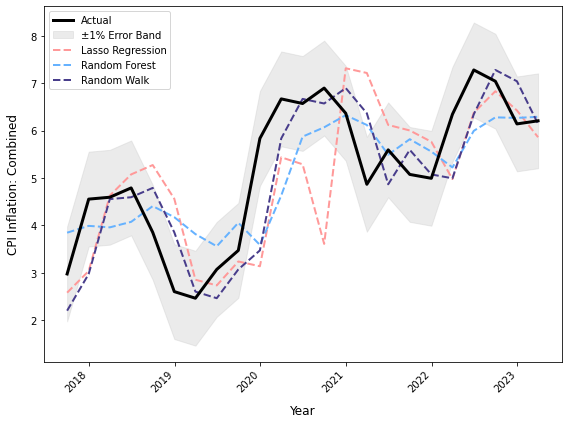

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Set up the plot
plt.figure(figsize=(8,6))
ax = plt.gca()

# Plot actual values with error band
actual_color = '#000000'
error_band_color = 'silver'#'#AAAAAA'
ax.plot(chrt.index, chrt['Actual'], label='Actual', color=actual_color, linewidth=3, zorder=5)

# Calculate and plot ±1% error band for actual values
error = 1  ##acceptable error
ax.fill_between(chrt.index, chrt['Actual'] - error, chrt['Actual'] + error, 
                color=error_band_color, alpha=0.3, label='±1% Error Band')

# Plot forecasted values
models = ['Lasso Regression', 'Random Forest', 'Random Walk']
colors = ['#FF9999', '#66B2FF', 'darkslateblue']

for model, color in zip(models, colors):
    ax.plot(chrt.index, chrt[model], label=f'{model}', color=color, linestyle='--', linewidth=2)

# Customize the plot
#ax.set_title('CPI Inflation: Actual vs Forecasted', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=12, labelpad=10)
ax.set_ylabel('CPI Inflation: Combined', fontsize=12, labelpad=10)

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, ha='right')

# Customize y-axis
#ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Customize legend
ax.legend(title='', fontsize=10, loc='upper left')

# Set background color
#ax.set_facecolor('#F8F8F8')

# Add a subtle border
#for spine in ax.spines.values():
#    spine.set_edgecolor('#CCCCCC')

# Adjust layout and display the plot
plt.tight_layout()
#plt.savefig("Plots/actual_vs_forecast_with_error_band.jpg", bbox_inches='tight', dpi=300)
plt.show()

In [9]:
##Baseline RW
actuals = [actual_mat["ax"][i,0] for i in range(24)]
rw = pd.DataFrame(actuals, index = range(24), columns=['actual'])
rw['actual_lag'] = rw["actual"].shift(1)
rw = rw.dropna() 
#rw = rw.fillna(4.55470737913486)
calculate_metrics(rw['actual_lag'], rw['actual'])

{'RMSE': 0.9185200846015591,
 'SMAPE': 15.77441337609568,
 "Theil's U": 0.08703654797686264,
 'MDRAE': 1.0}

In [10]:
from itertools import product

def nested_dict_to_df(data):
    # Flatten the nested dictionary
    flattened = []
    for key1, val1 in data.items():
        for key2, val2 in val1.items():
            for key3, val3 in val2.items():
                flattened.append([key1, key2, key3, val3])
    
    # Create DataFrame
    df = pd.DataFrame(flattened, columns=['Level1', 'Level2', 'Level3', 'Value'])
    
    # Set multi-level index
    df = df.set_index(['Level1', 'Level2', 'Level3'])
    
    # Unstack to create desired format
    return df.unstack(level=[1, 2])

# Usage
# Assuming your three-level nested dictionary is called 'data'
result_df = nested_dict_to_df(results_h1)

In [11]:
# Step 1: Melt the dataframe to create a long format
melted_df = result_df.T.reset_index().melt(id_vars=['Level2', 'Level3'], 
                                  var_name='Level1', 
                                  value_name='Value')

# Step 2: Pivot the melted dataframe to create the desired structure
reshaped_df = melted_df.pivot(index=['Level1', 'Level2'], 
                              columns='Level3', 
                              values='Value')

# Step 3: Sort the index levels if needed
reshaped_df = reshaped_df.sort_index(level=[0,1])

# Step 4: Optionally, you can rename the axes for clarity
reshaped_df.index.names = ['Level1', 'Level2']
reshaped_df.columns.name = 'Level3'

# Display the result
reshaped_df = reshaped_df.drop('level_0', level=0)


reshaped_df.to_csv('results_updated/horizon2_optim.csv')

In [12]:
reshaped_df.head()

Level3              MDRAE      RMSE      SMAPE Theil's U
Level1   Level2                                         
backward ax      1.538968  1.766616  26.537102  0.166436
         lasso   1.249495  1.340915  21.191379  0.128612
         rf      1.395412  1.051735  20.277859  0.101343
         ridge   1.463208  1.458725   22.77795  0.138344
         xgb     1.187903  1.139161  19.210944  0.108992

In [13]:
# scaled_df = pd.DataFrame()
# for spc in ["backward","forward","hybrid"]:
#     dt = reshaped_df.copy()
#     dt = dt.loc[spc]/dt.loc[spc].max(axis = 0)
#     scaled_df = pd.concat([scaled_df,dt], axis = 0)
    
# scaled_df
    

### Different measures of Outputgap and Inflation using HP (Robustness Checks)

In [18]:
data = pd.read_excel('Quarterly PC.xlsx', sheet_name = "base", index_col="Quarter")
data = data.dropna()
data.head()

,LGDP_SA,Inflation,Crude_YoY,FX_YoY,Rainfall_YoY,GDP_YoY,Spread
Quarter,,,,,,,
2000-03-31,5.994324,3.682946,12.367955,-0.311607,-5.298,7.256904,-0.928028
2000-06-30,5.993762,5.263158,0.320499,-1.270943,27.982,5.240857,-0.356975
2000-09-30,5.999228,4.143862,11.516271,-2.862946,-100.646,6.635891,-0.405525
2000-12-31,5.998034,2.986217,-0.655218,-2.541632,-59.278,3.798058,-0.186281
2001-03-31,6.001272,2.934363,-12.050431,0.144614,-30.420,1.092346,-0.277494


In [19]:

def initialize_prediction_matrices(frcst_length):
    """Initialize matrices to store predictions and actual values."""
    models = ['ax', 'ridge', 'lasso', 'rf', 'xgb']#, 'lgb']
    pred_mat = {model: np.zeros((frcst_length, 1)) for model in models}
    actual_mat = {model: np.zeros((frcst_length, 1)) for model in models}
    return pred_mat, actual_mat

def fit_unobserved_components_model(data, column):
    """Fit an unobserved components model."""
    unrestricted_model = {
        'level': 'local linear trend',
        'cycle': True,
        'damped_cycle': True,
        'stochastic_cycle': True
    }
    mod = sm.tsa.UnobservedComponents(data[column], **unrestricted_model)
    res = mod.fit(method='powell', disp=False)
    return res

def fit_hpfilter(data, column):
    cycle, trend = hpfilter(data[column], lamb=1600)

    return {'cycle': cycle,
            'trend':trend}

def prepare_data(data, train_index):
    """Prepare data for model fitting."""
    dat = data.iloc[:train_index + 1, :].copy()
    
    # Fit unobserved components models
    output_res = fit_hpfilter(dat.iloc[:-1, :], 'LGDP_SA')
    inflation_res = fit_hpfilter(dat.iloc[:-1, :], 'Inflation')
    
    # Calculate expected inflation and output gap
    dat['exp_inf'] = list(inflation_res["trend"]) + [np.nan]
    dat['ogap'] = list(output_res["cycle"] * 100) + [np.nan]
    dat['exp_inf_ahead'] = dat['exp_inf'].shift(1)
    
    # Generate lags
    dat['Inf_lag_1'] = dat['Inflation'].shift(1)
    for lag in range(1, 5):
        for col in ['FX_YoY', 'Crude_YoY', 'Rainfall_YoY', 'ogap', 'GDP_YoY', 'Spread']:
            dat[f'{col}_lag_{lag}'] = dat[col].shift(lag)
    th = dat.shape[1] - 3 ##threshold to dropnans
    
    return dat.dropna(thresh=th)
    

def get_train_test(data, spec):
    """Extract features and target from prepared data."""
    dat1 = data.iloc[:-1, :].dropna()
    if spec=="backward":
        exog = dat1.iloc[:-1, [2,3,4,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]]
        test = dat1.iloc[-1, [2,3,4,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]].values.reshape(1, -1)
    elif spec=="forward":
        exog = dat1.iloc[:-1, [2,3,4,9,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]]
        test = dat1.iloc[-1, [2,3,4,9,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]].values.reshape(1, -1)
    elif spec=="hybrid":
        exog = dat1.iloc[:-1, [2,3,4,9,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]]
        test = dat1.iloc[-1, [2,3,4,9,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]].values.reshape(1, -1)
    target = dat1["Inflation"].iloc[:-1]
    return exog, target,test
    

def fit_and_predict(model, exog, target, x_test):
    """Fit a model and make predictions."""
    fitted_model = model.fit(exog, target)
    return fitted_model.predict(x_test)

def forecasting_loop(data, train, frcst_length, spec):
    """Main forecasting loop."""
    pred_mat, actual_mat = initialize_prediction_matrices(frcst_length)
    
    for i in range(frcst_length):
        dat = prepare_data(data, train + i)
        actual = dat.iloc[-1, 1]
        exog, target, test = get_train_test(dat, spec)
        
                # Initialize models    
    models = {
        'ax': LinearRegression(),
        'ridge': RidgeCV(),
        'lasso': LassoCV(),
        'rf': RandomForestRegressor(random_state=42),
        'xgb': xgb.XGBRegressor(random_state=42)
    }
    
    for i in range(frcst_length):
        dat = prepare_data(data, train + i)
        actual = dat.iloc[-1, 1]
        exog, target, test = get_train_test(dat, spec)
        
        # RF and XGBoost optimization (only in the first pass)
        if i == 0:
            # Random Forest optimization
            rf_param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5, 10]
            }
            rf_grid = GridSearchCV(models['rf'], rf_param_grid, cv=5)
            rf_grid.fit(exog, target)
            models['rf'] = rf_grid.best_estimator_
            
            # XGBoost optimization
            xgb_param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.1, 0.3]
            }
            xgb_grid = GridSearchCV(models['xgb'], xgb_param_grid, cv=5)
            xgb_grid.fit(exog, target)
            models['xgb'] = xgb_grid.best_estimator_
        
        for model_name, model in models.items():
            preds = fit_and_predict(model, exog, target, test)
            pred_mat[model_name][i, :] = preds
            actual_mat[model_name][i, :] = actual
    
    return pred_mat, actual_mat

def main(data, spec):
    T = len(data)
    train = T - 24 ##change this 24 value for multi-period forecasts
    frcst_length = T - train
    
    print(T, train, frcst_length)
    
    pred_mat, actual_mat = forecasting_loop(data, train, frcst_length, spec)
    
    return pred_mat, actual_mat



In [20]:
specs = ['forward', 'backward', 'hybrid']
mods = ['ax', 'ridge', 'lasso','rf','xgb']

results_h1 = {}
for specf in specs:
    pred_mat, actual_mat = main(data, spec = specf)
    metrics = {}
    for mod in mods:
        metrics[mod] = calculate_metrics(pred_mat[mod], actual_mat[mod])
    results_h1[specf] = metrics

93 69 24
93 69 24
93 69 24


In [21]:
from itertools import product

def nested_dict_to_df(data):
    # Flatten the nested dictionary
    flattened = []
    for key1, val1 in data.items():
        for key2, val2 in val1.items():
            for key3, val3 in val2.items():
                flattened.append([key1, key2, key3, val3])
    
    # Create DataFrame
    df = pd.DataFrame(flattened, columns=['Level1', 'Level2', 'Level3', 'Value'])
    
    # Set multi-level index
    df = df.set_index(['Level1', 'Level2', 'Level3'])
    
    # Unstack to create desired format
    return df.unstack(level=[1, 2])

# Usage
# Assuming your three-level nested dictionary is called 'data'
result_df = nested_dict_to_df(results_h1)


# Step 1: Melt the dataframe to create a long format
melted_df = result_df.T.reset_index().melt(id_vars=['Level2', 'Level3'], 
                                  var_name='Level1', 
                                  value_name='Value')

# Step 2: Pivot the melted dataframe to create the desired structure
reshaped_df = melted_df.pivot(index=['Level1', 'Level2'], 
                              columns='Level3', 
                              values='Value')

# Step 3: Sort the index levels if needed
reshaped_df = reshaped_df.sort_index(level=[0,1])

# Step 4: Optionally, you can rename the axes for clarity
reshaped_df.index.names = ['Level1', 'Level2']
reshaped_df.columns.name = 'Level3'

# Display the result
reshaped_df = reshaped_df.drop('level_0', level=0)

reshaped_df.to_csv('results_updated/horizon1_hp.csv')

### Using a PC of Supply shocks

In [25]:
data = pd.read_excel('Quarterly PC.xlsx', sheet_name = "Sheet_with_PCA", index_col="Quarter").iloc[:,[0,1,2,3,4,6,7]]
data = data.dropna()
data.head()

,LGDP_SA,Inflation,Crude_YoY,FX_YoY,Rainfall_YoY,Spread,avg_shock
Quarter,,,,,,,
2000-03-31,5.994324,3.682946,12.367955,-0.311607,-5.298,-0.928028,0.324483
2000-06-30,5.993762,5.263158,0.320499,-1.270943,27.982,-0.356975,0.177846
2000-09-30,5.999228,4.143862,11.516271,-2.862946,-100.646,-0.405525,-0.628031
2000-12-31,5.998034,2.986217,-0.655218,-2.541632,-59.278,-0.186281,-0.583414
2001-03-31,6.001272,2.934363,-12.050431,0.144614,-30.420,-0.277494,-0.352204


In [26]:
#data['PC_supplyshocks'] = generate_pc(data.iloc[:,[2,3,4,6]])
#data.to_csv('results_updated/data_with_pc.csv')

In [27]:

def initialize_prediction_matrices(frcst_length):
    """Initialize matrices to store predictions and actual values."""
    models = ['ax', 'ridge', 'lasso', 'rf', 'xgb']#, 'lgb']
    pred_mat = {model: np.zeros((frcst_length, 1)) for model in models}
    actual_mat = {model: np.zeros((frcst_length, 1)) for model in models}
    return pred_mat, actual_mat

def fit_unobserved_components_model(data, column):
    """Fit an unobserved components model."""
    unrestricted_model = {
        'level': 'local linear trend',
        'cycle': True,
        'damped_cycle': True,
        'stochastic_cycle': True
    }
    mod = sm.tsa.UnobservedComponents(data[column], **unrestricted_model)
    res = mod.fit(method='powell', disp=False)
    return res

def prepare_data(data, train_index):
    """Prepare data for model fitting."""
    dat = data.iloc[:train_index + 1, :].copy()
    
    # Fit unobserved components models
    output_res = fit_unobserved_components_model(dat.iloc[:-1, :], 'LGDP_SA')
    inflation_res = fit_unobserved_components_model(dat.iloc[:-1, :], 'Inflation')
    
    # Calculate expected inflation and output gap
    dat['exp_inf'] = list(inflation_res.level["smoothed"]) + [np.nan]
    dat['ogap'] = list(output_res.cycle["smoothed"] * 100) + [np.nan]
    dat['exp_inf_ahead'] = dat['exp_inf'].shift(1)
    
    # Generate lags
    dat['Inf_lag_1'] = dat['Inflation'].shift(1)
    for lag in range(1, 5):
        for col in ["avg_shock", "ogap"]:
            dat[f'{col}_lag_{lag}'] = dat[col].shift(lag)
    
    th = dat.shape[1] - 3 ##threshold to dropnans
    
    return dat.dropna(thresh=th)

def get_train_test(data, spec):
    """Extract features and target from prepared data."""
    dat1 = data.iloc[:-1, :].dropna()
    if spec=="backward":
        exog = dat1.iloc[:-1, [10,11,12,13,14,15,16,17,18]]
        test = dat1.iloc[-1, [10,11,12,13,14,15,16,17,18]].values.reshape(1, -1)
    elif spec=="forward":
        exog = dat1.iloc[:-1, [9,11,12,13,14,15,16,17,18]]
        test = dat1.iloc[-1, [9,11,12,13,14,15,16,17,18]].values.reshape(1, -1)
    elif spec=="hybrid":
        exog = dat1.iloc[:-1, [9,10,11,12,13,14,15,16,17,18]]
        test = dat1.iloc[-1, [9,10,11,12,13,14,15,16,17,18]].values.reshape(1, -1)
    target = dat1["Inflation"].iloc[:-1]
    return exog, target,test
    

def fit_and_predict(model, exog, target, x_test):
    """Fit a model and make predictions."""
    fitted_model = model.fit(exog, target)
    return fitted_model.predict(x_test)

def forecasting_loop(data, train, frcst_length, spec):
    """Main forecasting loop."""
    pred_mat, actual_mat = initialize_prediction_matrices(frcst_length)
    
    for i in range(frcst_length):
        dat = prepare_data(data, train + i)
        actual = dat.iloc[-1, 1]
        exog, target, test = get_train_test(dat, spec)
        
        # Initialize models    
    models = {
        'ax': LinearRegression(),
        'ridge': RidgeCV(),
        'lasso': LassoCV(),
        'rf': RandomForestRegressor(random_state=42),
        'xgb': xgb.XGBRegressor(random_state=42)
    }
    
    for i in range(frcst_length):
        dat = prepare_data(data, train + i)
        actual = dat.iloc[-1, 1]
        exog, target, test = get_train_test(dat, spec)
        
        # RF and XGBoost optimization (only in the first pass)
        if i == 0:
            # Random Forest optimization
            rf_param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5, 10]
            }
            rf_grid = GridSearchCV(models['rf'], rf_param_grid, cv=5)
            rf_grid.fit(exog, target)
            models['rf'] = rf_grid.best_estimator_
            
            # XGBoost optimization
            xgb_param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.1, 0.3]
            }
            xgb_grid = GridSearchCV(models['xgb'], xgb_param_grid, cv=5)
            xgb_grid.fit(exog, target)
            models['xgb'] = xgb_grid.best_estimator_
        
        for model_name, model in models.items():
            preds = fit_and_predict(model, exog, target, test)
            pred_mat[model_name][i, :] = preds
            actual_mat[model_name][i, :] = actual
    
    return pred_mat, actual_mat

def main(data, spec):
    T = len(data)
    train = T - 24 ##change this 24 value for multi-period forecasts
    frcst_length = T - train
    
    print(T, train, frcst_length)
    
    pred_mat, actual_mat = forecasting_loop(data, train, frcst_length, spec)
    
    return pred_mat, actual_mat

In [28]:
specs = ['forward', 'backward', 'hybrid']
mods = ['ax', 'ridge', 'lasso','rf','xgb']

results_h1 = {}
for specf in specs:
    pred_mat, actual_mat = main(data, spec = specf)
    metrics = {}
    for mod in mods:
        metrics[mod] = calculate_metrics(pred_mat[mod], actual_mat[mod])
    results_h1[specf] = metrics

93 69 24
93 69 24
93 69 24


In [29]:
from itertools import product

def nested_dict_to_df(data):
    # Flatten the nested dictionary
    flattened = []
    for key1, val1 in data.items():
        for key2, val2 in val1.items():
            for key3, val3 in val2.items():
                flattened.append([key1, key2, key3, val3])
    
    # Create DataFrame
    df = pd.DataFrame(flattened, columns=['Level1', 'Level2', 'Level3', 'Value'])
    
    # Set multi-level index
    df = df.set_index(['Level1', 'Level2', 'Level3'])
    
    # Unstack to create desired format
    return df.unstack(level=[1, 2])

# Usage
# Assuming your three-level nested dictionary is called 'data'
result_df = nested_dict_to_df(results_h1)


# Step 1: Melt the dataframe to create a long format
melted_df = result_df.T.reset_index().melt(id_vars=['Level2', 'Level3'], 
                                  var_name='Level1', 
                                  value_name='Value')

# Step 2: Pivot the melted dataframe to create the desired structure
reshaped_df = melted_df.pivot(index=['Level1', 'Level2'], 
                              columns='Level3', 
                              values='Value')

# Step 3: Sort the index levels if needed
reshaped_df = reshaped_df.sort_index(level=[0,1])

# Step 4: Optionally, you can rename the axes for clarity
reshaped_df.index.names = ['Level1', 'Level2']
reshaped_df.columns.name = 'Level3'

# Display the result
reshaped_df = reshaped_df.drop('level_0', level=0)

reshaped_df.to_csv('results_updated/horizon1_avg1.csv')

### Using Bichhal measure of Inflation expectations

In [3]:
data = pd.read_excel('Quarterly PC.xlsx', sheet_name = "With Bichal_inf", index_col="Quarter")
data = data.dropna()
data.head()

,LGDP_SA,Inflation,Crude_YoY,FX_YoY,Rainfall_YoY,Bichal_Inf,Spread
Quarter,,,,,,,
2004-03-31,6.078178,3.988996,9.372397,0.559212,-19.890,3.682185,-0.203761
2004-06-30,6.092710,2.695418,10.842114,0.648053,25.512,3.747081,-0.095797
2004-09-30,6.104524,4.202802,13.819473,-2.609135,-103.814,6.102011,0.130400
2004-12-31,6.109201,4.174950,5.329073,2.807069,-11.634,5.137276,0.237236
2005-03-31,6.119219,4.232804,8.341767,2.727665,61.100,4.186937,0.114828


In [4]:

def initialize_prediction_matrices(frcst_length):
    """Initialize matrices to store predictions and actual values."""
    models = ['ax', 'ridge', 'lasso', 'rf', 'xgb']#, 'lgb']
    pred_mat = {model: np.zeros((frcst_length, 1)) for model in models}
    actual_mat = {model: np.zeros((frcst_length, 1)) for model in models}
    return pred_mat, actual_mat

def fit_unobserved_components_model(data, column):
    """Fit an unobserved components model."""
    unrestricted_model = {
        'level': 'local linear trend',
        'cycle': True,
        'damped_cycle': True,
        'stochastic_cycle': True
    }
    mod = sm.tsa.UnobservedComponents(data[column], **unrestricted_model)
    res = mod.fit(method='powell', disp=False)
    return res

def prepare_data(data, train_index):
    """Prepare data for model fitting."""
    dat = data.iloc[:train_index + 1, :].copy()
    
    # Fit unobserved components models
    output_res = fit_unobserved_components_model(dat.iloc[:-1, :], 'LGDP_SA')
    inflation_res = fit_unobserved_components_model(dat.iloc[:-1, :], 'Inflation')
    
    # Calculate expected inflation and output gap
    dat['exp_inf'] = list(inflation_res.level["smoothed"]) + [np.nan]
    dat['ogap'] = list(output_res.cycle["smoothed"] * 100) + [np.nan]
    dat['exp_inf_ahead'] = dat['exp_inf'].shift(1)
    
    # Generate lags
    dat['Inf_lag_1'] = dat['Inflation'].shift(1)
    for lag in range(1, 5):
        for col in ['FX_YoY', 'Crude_YoY', 'Rainfall_YoY', 'ogap', 'Bichal_Inf', 'Spread']:
            dat[f'{col}_lag_{lag}'] = dat[col].shift(lag)
    
    th = dat.shape[1] - 3 ##threshold to dropnans
    return dat.dropna(thresh=th)

def get_train_test(data, spec):
    """Extract features and target from prepared data."""
    dat1 = data.iloc[:-1, :].dropna()
    if spec=="backward":
        exog = dat1.iloc[:-1, [2,3,4,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]]
        test = dat1.iloc[-1, [2,3,4,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]].values.reshape(1, -1)
    elif spec=="forward":
        exog = dat1.iloc[:-1, [2,3,4,5,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]]
        test = dat1.iloc[-1, [2,3,4,5,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]].values.reshape(1, -1)
    elif spec=="hybrid":
        exog = dat1.iloc[:-1, [2,3,4,5,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]]
        test = dat1.iloc[-1, [2,3,4,5,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]].values.reshape(1, -1)
    target = dat1["Inflation"].iloc[:-1]
    return exog, target,test
    

def fit_and_predict(model, exog, target, x_test):
    """Fit a model and make predictions."""
    fitted_model = model.fit(exog, target)
    return fitted_model.predict(x_test)

def forecasting_loop(data, train, frcst_length, spec):
    """Main forecasting loop."""
    pred_mat, actual_mat = initialize_prediction_matrices(frcst_length)
    
    for i in range(frcst_length):
        dat = prepare_data(data, train + i)
        actual = dat.iloc[-1, 1]
        exog, target, test = get_train_test(dat, spec)
        
            # Initialize models    
    models = {
        'ax': LinearRegression(),
        'ridge': RidgeCV(),
        'lasso': LassoCV(),
        'rf': RandomForestRegressor(random_state=42),
        'xgb': xgb.XGBRegressor(random_state=42)
    }
    
    for i in range(frcst_length):
        dat = prepare_data(data, train + i)
        actual = dat.iloc[-1, 1]
        exog, target, test = get_train_test(dat, spec)
        
        # RF and XGBoost optimization (only in the first pass)
        if i == 0:
            # Random Forest optimization
            rf_param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5, 10]
            }
            rf_grid = GridSearchCV(models['rf'], rf_param_grid, cv=5)
            rf_grid.fit(exog, target)
            models['rf'] = rf_grid.best_estimator_
            
            # XGBoost optimization
            xgb_param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.1, 0.3]
            }
            xgb_grid = GridSearchCV(models['xgb'], xgb_param_grid, cv=5)
            xgb_grid.fit(exog, target)
            models['xgb'] = xgb_grid.best_estimator_
        
        for model_name, model in models.items():
            preds = fit_and_predict(model, exog, target, test)
            pred_mat[model_name][i, :] = preds
            actual_mat[model_name][i, :] = actual
    
    return pred_mat, actual_mat

def main(data, spec):
    T = len(data)
    train = T - 12 ##change this 24 value for multi-period forecasts
    frcst_length = T - train
    
    print(T, train, frcst_length)
    
    pred_mat, actual_mat = forecasting_loop(data, train, frcst_length, spec)
    
    return pred_mat, actual_mat

In [5]:
specs = ['forward', 'backward', 'hybrid']
mods = ['ax', 'ridge', 'lasso','rf','xgb']

results_h1 = {}
for specf in specs:
    pred_mat, actual_mat = main(data, spec = specf)
    metrics = {}
    for mod in mods:
        metrics[mod] = calculate_metrics(pred_mat[mod], actual_mat[mod])
    results_h1[specf] = metrics

77 65 12
77 65 12
77 65 12


In [6]:
##Baseline RW
actuals = [actual_mat["ax"][i,0] for i in range(12)]
rw = pd.DataFrame(actuals, index = range(12), columns=['actual'])
rw['actual_lag'] = rw["actual"].shift(1)
rw = rw.fillna(6.571227)
calculate_metrics(rw['actual_lag'], rw['actual'])

{'RMSE': 0.7638446705935323,
 'SMAPE': 10.0258468459007,
 "Theil's U": 0.06180171065805867,
 'MDRAE': 1.0}

In [33]:
from itertools import product

def nested_dict_to_df(data):
    # Flatten the nested dictionary
    flattened = []
    for key1, val1 in data.items():
        for key2, val2 in val1.items():
            for key3, val3 in val2.items():
                flattened.append([key1, key2, key3, val3])
    
    # Create DataFrame
    df = pd.DataFrame(flattened, columns=['Level1', 'Level2', 'Level3', 'Value'])
    
    # Set multi-level index
    df = df.set_index(['Level1', 'Level2', 'Level3'])
    
    # Unstack to create desired format
    return df.unstack(level=[1, 2])

# Usage
# Assuming your three-level nested dictionary is called 'data'
result_df = nested_dict_to_df(results_h1)


# Step 1: Melt the dataframe to create a long format
melted_df = result_df.T.reset_index().melt(id_vars=['Level2', 'Level3'], 
                                  var_name='Level1', 
                                  value_name='Value')

# Step 2: Pivot the melted dataframe to create the desired structure
reshaped_df = melted_df.pivot(index=['Level1', 'Level2'], 
                              columns='Level3', 
                              values='Value')

# Step 3: Sort the index levels if needed
reshaped_df = reshaped_df.sort_index(level=[0,1])

# Step 4: Optionally, you can rename the axes for clarity
reshaped_df.index.names = ['Level1', 'Level2']
reshaped_df.columns.name = 'Level3'

# Display the result
reshaped_df = reshaped_df.drop('level_0', level=0)


reshaped_df.to_csv('results_updated/horizon1_bichal.csv')

### Using optimisation for RF and XGboost

In [14]:
data = pd.read_excel('Quarterly PC.xlsx', sheet_name ="base", index_col="Quarter")
data = data.dropna()

#data["Inflation"] = data["Inflation"].shift(-3)  ## Edit this for Multiperiod ahead forecasts
#data = data.dropna()
data.head()


,LGDP_SA,Inflation,Crude_YoY,FX_YoY,Rainfall_YoY,GDP_YoY,Spread
Quarter,,,,,,,
2000-03-31,5.994324,3.682946,12.367955,-0.311607,-5.298,7.256904,-0.928028
2000-06-30,5.993762,5.263158,0.320499,-1.270943,27.982,5.240857,-0.356975
2000-09-30,5.999228,4.143862,11.516271,-2.862946,-100.646,6.635891,-0.405525
2000-12-31,5.998034,2.986217,-0.655218,-2.541632,-59.278,3.798058,-0.186281
2001-03-31,6.001272,2.934363,-12.050431,0.144614,-30.420,1.092346,-0.277494


In [90]:

def initialize_prediction_matrices(frcst_length):
    """Initialize matrices to store predictions and actual values."""
    models = ['ax', 'ridge', 'lasso', 'rf', 'xgb']#, 'lgb']
    pred_mat = {model: np.zeros((frcst_length, 1)) for model in models}
    actual_mat = {model: np.zeros((frcst_length, 1)) for model in models}
    return pred_mat, actual_mat

def fit_unobserved_components_model(data, column):
    """Fit an unobserved components model."""
    unrestricted_model = {
        'level': 'local linear trend',
        'cycle': True,
        'damped_cycle': True,
        'stochastic_cycle': True
    }
    mod = sm.tsa.UnobservedComponents(data[column], **unrestricted_model)
    res = mod.fit(method='powell', disp=False)
    return res

def prepare_data(data, train_index):
    """Prepare data for model fitting."""
    dat = data.iloc[:train_index + 1, :].copy()
    
    # Fit unobserved components models
    output_res = fit_unobserved_components_model(dat.iloc[:-1, :], 'LGDP_SA')
    inflation_res = fit_unobserved_components_model(dat.iloc[:-1, :], 'Inflation')
    
    # Calculate expected inflation and output gap
    dat['exp_inf'] = list(inflation_res.level["smoothed"]) + [np.nan]
    dat['ogap'] = list(output_res.cycle["smoothed"] * 100) + [np.nan]
    dat['exp_inf_ahead'] = dat['exp_inf'].shift(1)
    
    # Generate lags
    dat['Inf_lag_1'] = dat['Inflation'].shift(1)
    for lag in range(1, 5):
        for col in ['FX_YoY', 'Crude_YoY', 'Rainfall_YoY', 'ogap', 'GDP_YoY', 'Spread']:
            dat[f'{col}_lag_{lag}'] = dat[col].shift(lag)
    
    th = dat.shape[1] - 3 ##threshold to dropnans
    
    return dat.dropna(thresh=th)

def get_train_test(data, spec):
    """Extract features and target from prepared data."""
    dat1 = data#.iloc[:-1, :].dropna()
    if spec=="backward":
        exog = dat1.iloc[:-1, [2,3,4,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]]
        test = dat1.iloc[-1, [2,3,4,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]].values.reshape(1, -1)
    elif spec=="forward":
        exog = dat1.iloc[:-1, [2,3,4,6,9,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]]
        test = dat1.iloc[-1, [2,3,4,6,9,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]].values.reshape(1, -1)
    elif spec=="hybrid":
        exog = dat1.iloc[:-1, [2,3,4,6,9,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]]
        test = dat1.iloc[-1, [2,3,4,6,9,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]].values.reshape(1, -1)
    target = dat1["Inflation"].iloc[:-1]
    return exog, target,test
    

def fit_and_predict(model, exog, target, x_test):
    """Fit a model and make predictions."""
    fitted_model = model.fit(exog, target)
    return fitted_model.predict(x_test)

def forecasting_loop(data, train, frcst_length, spec):
    """Main forecasting loop."""
    pred_mat, actual_mat = initialize_prediction_matrices(frcst_length)
    
    for i in range(frcst_length):
        dat = prepare_data(data, train + i)
        actual = dat.iloc[-1, 1]
        exog, target, test = get_train_test(dat, spec)
        
    # Initialize models    
    models = {
        'ax': LinearRegression(),
        'ridge': RidgeCV(),
        'lasso': LassoCV(),
        'rf': RandomForestRegressor(random_state=42),
        'xgb': xgb.XGBRegressor(random_state=42)
    }
    
    for i in range(frcst_length):
        dat = prepare_data(data, train + i)
        actual = dat.iloc[-1, 1]
        exog, target, test = get_train_test(dat, spec)
        
        # RF and XGBoost optimization (only in the first pass)
        if i == 0:
            # Random Forest optimization
            rf_param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5, 10]
            }
            rf_grid = GridSearchCV(models['rf'], rf_param_grid, cv=5)
            rf_grid.fit(exog, target)
            models['rf'] = rf_grid.best_estimator_
            
            # XGBoost optimization
            xgb_param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.1, 0.3]
            }
            xgb_grid = GridSearchCV(models['xgb'], xgb_param_grid, cv=5)
            xgb_grid.fit(exog, target)
            models['xgb'] = xgb_grid.best_estimator_
        
        for model_name, model in models.items():
            preds = fit_and_predict(model, exog, target, test)
            pred_mat[model_name][i, :] = preds
            actual_mat[model_name][i, :] = actual
    
    return pred_mat, actual_mat

def main(data, spec):
    T = len(data)
    train = T - 21 ##change this 24 value for multi-period forecasts
    frcst_length = T - train
    
    print(T, train, frcst_length)
    
    pred_mat, actual_mat = forecasting_loop(data, train, frcst_length, spec)
    
    return pred_mat, actual_mat

In [91]:
specs = ['backward', 'hybrid', 'forward']
mods = ['ax', 'ridge', 'lasso','rf','xgb']

results_h1 = {}
for specf in specs:
    pred_mat, actual_mat = main(data, spec = specf)
    metrics = {}
    for mod in mods:
        metrics[mod] = calculate_metrics(pred_mat[mod], actual_mat[mod])
    results_h1[specf] = metrics

90 69 21
90 69 21
90 69 21


In [92]:
from itertools import product

def nested_dict_to_df(data):
    # Flatten the nested dictionary
    flattened = []
    for key1, val1 in data.items():
        for key2, val2 in val1.items():
            for key3, val3 in val2.items():
                flattened.append([key1, key2, key3, val3])
    
    # Create DataFrame
    df = pd.DataFrame(flattened, columns=['Level1', 'Level2', 'Level3', 'Value'])
    
    # Set multi-level index
    df = df.set_index(['Level1', 'Level2', 'Level3'])
    
    # Unstack to create desired format
    return df.unstack(level=[1, 2])

# Usage
# Assuming your three-level nested dictionary is called 'data'
result_df = nested_dict_to_df(results_h1)


# Step 1: Melt the dataframe to create a long format
melted_df = result_df.T.reset_index().melt(id_vars=['Level2', 'Level3'], 
                                  var_name='Level1', 
                                  value_name='Value')

# Step 2: Pivot the melted dataframe to create the desired structure
reshaped_df = melted_df.pivot(index=['Level1', 'Level2'], 
                              columns='Level3', 
                              values='Value')

# Step 3: Sort the index levels if needed
reshaped_df = reshaped_df.sort_index(level=[0,1])

# Step 4: Optionally, you can rename the axes for clarity
reshaped_df.index.names = ['Level1', 'Level2']
reshaped_df.columns.name = 'Level3'

# Display the result
reshaped_df = reshaped_df.drop('level_0', level=0)


#reshaped_df.to_csv('results_updated/horizon4_optim.csv')

### Feature importance and explanations (Old code for explanations(not used))

In [29]:
data = pd.read_excel('Quarterly PC.xlsx', sheet_name = "base", index_col="Quarter")#.loc[:"2016"]
data = data.dropna()
data.tail()

,LGDP_SA,Inflation,Crude_YoY,FX_YoY,Rainfall_YoY,GDP_YoY,Spread
Quarter,,,,,,,
2022-03-31,6.583204,6.344475,23.425214,-0.389598,-2.6,3.958153,0.355913
2022-06-30,6.604842,7.278415,13.955013,-2.589443,7.5,13.084520,-0.399106
2022-09-30,6.596149,7.040524,-12.422674,-3.207663,69.5,6.198306,-1.098298
2022-12-31,6.597467,6.140879,-11.582914,-2.909523,23.0,4.462819,-1.396664
2023-03-31,6.607603,6.206206,-7.285191,-0.069313,-17.8,6.058686,-1.599543


In [30]:
def fit_unobserved_components_model(data, column):
    """Fit an unobserved components model."""
    unrestricted_model = {
        'level': 'local linear trend',
        'cycle': True,
        'damped_cycle': True,
        'stochastic_cycle': True
    }
    mod = sm.tsa.UnobservedComponents(data[column], **unrestricted_model)
    res = mod.fit(method='powell', disp=False)
    return res


def fit_hpfilter(data, column):
    cycle, trend = hpfilter(data[column], lamb=1600)

    return {'cycle': cycle,
            'trend':trend}
    
data['ogap'] = fit_unobserved_components_model(data, "LGDP_SA").cycle["smoothed"]*100
data['trend_inf'] = fit_unobserved_components_model(data, "Inflation").level["smoothed"]
data['exp_inf_ahead'] = data['trend_inf'].shift(1)
data['Inf_lag_1'] = data['Inflation'].shift(1)

for lag in range(1, 5):
    for col in ['FX_YoY', 'Crude_YoY', 'Rainfall_YoY', 'ogap']:
        data[f'{col}_lag_{lag}'] = data[col].shift(lag)

data = data.dropna()
data.tail()

,LGDP_SA,Inflation,Crude_YoY,FX_YoY,Rainfall_YoY,GDP_YoY,Spread,ogap,trend_inf,exp_inf_ahead,...,Rainfall_YoY_lag_2,ogap_lag_2,FX_YoY_lag_3,Crude_YoY_lag_3,Rainfall_YoY_lag_3,ogap_lag_3,FX_YoY_lag_4,Crude_YoY_lag_4,Rainfall_YoY_lag_4,ogap_lag_4
Quarter,,,,,,,,,,,,,,,,,,,,,
2022-03-31,6.583204,6.344475,23.425214,-0.389598,-2.6,3.958153,0.355913,-0.205293,6.177344,6.046898,...,-21.6,0.093452,-1.144902,13.073132,57.42,-0.883531,1.176359,35.871585,-23.89,0.992787
2022-06-30,6.604842,7.278415,13.955013,-2.589443,7.5,13.084520,-0.399106,0.938293,6.293807,6.177344,...,53.9,0.027694,-0.484793,6.858781,-21.60,0.093452,-1.144902,13.073132,57.42,-0.883531
2022-09-30,6.596149,7.040524,-12.422674,-3.207663,69.5,6.198306,-1.098298,-0.141216,6.385267,6.293807,...,-2.6,-0.205293,-1.156781,9.256416,53.90,0.027694,-0.484793,6.858781,-21.60,0.093452
2022-12-31,6.597467,6.140879,-11.582914,-2.909523,23.0,4.462819,-1.396664,-0.364077,6.461850,6.385267,...,7.5,0.938293,-0.389598,23.425214,-2.60,-0.205293,-1.156781,9.256416,53.90,0.027694
2023-03-31,6.607603,6.206206,-7.285191,-0.069313,-17.8,6.058686,-1.599543,-0.006742,6.555529,6.461850,...,69.5,-0.141216,-2.589443,13.955013,7.50,0.938293,-0.389598,23.425214,-2.60,-0.205293


In [31]:
#data.to_csv("dt.csv")

In [32]:
target = data['Inflation']
exog_hybrid = data.iloc[:, [2,3,4,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]]
exog_hybrid.columns

Index(['Crude_YoY', 'FX_YoY', 'Rainfall_YoY', 'exp_inf_ahead', 'Inf_lag_1',
       'FX_YoY_lag_1', 'Crude_YoY_lag_1', 'Rainfall_YoY_lag_1', 'ogap_lag_1',
       'FX_YoY_lag_2', 'Crude_YoY_lag_2', 'Rainfall_YoY_lag_2', 'ogap_lag_2',
       'FX_YoY_lag_3', 'Crude_YoY_lag_3', 'Rainfall_YoY_lag_3', 'ogap_lag_3',
       'FX_YoY_lag_4', 'Crude_YoY_lag_4', 'Rainfall_YoY_lag_4', 'ogap_lag_4'],
      dtype='object')

In [33]:
import random
random.seed(23)
rf_model = RandomForestRegressor(random_state = 42).fit(exog_hybrid, target)
lr_model = LinearRegression().fit(exog_hybrid, target)
explainer_rf = shap.TreeExplainer(rf_model, exog_hybrid)
explainer_lr = shap.Explainer(lr_model, exog_hybrid)

In [34]:
shap_values_rf = explainer_rf(exog_hybrid)
shap_values_lr = explainer_lr(exog_hybrid)

In [35]:
absolute_mean_shap_rf = np.abs(shap_values_rf.values).mean(axis = 0)
absolute_mean_shap_lr = np.abs(shap_values_lr.values).mean(axis = 0)

In [36]:
df = pd.DataFrame(
   dict(
      vars= exog_hybrid.columns,
      shap=absolute_mean_shap_rf
   )
)
df2 = df.sort_values(by = 'shap', ascending = False)
df2

,vars,shap
3,exp_inf_ahead,1.399200
4,Inf_lag_1,0.665087
15,Rainfall_YoY_lag_3,0.071692
2,Rainfall_YoY,0.048340
16,ogap_lag_3,0.031594
11,Rainfall_YoY_lag_2,0.030703
5,FX_YoY_lag_1,0.026377
0,Crude_YoY,0.024912
18,Crude_YoY_lag_4,0.023423
19,Rainfall_YoY_lag_4,0.022089


In [37]:
df = pd.DataFrame(
   dict(
      vars= exog_hybrid.columns,
      shap=absolute_mean_shap_lr
   )
)
df2 = df.sort_values(by = 'shap', ascending = False)
df2

,vars,shap
4,Inf_lag_1,1.286213
3,exp_inf_ahead,0.817898
1,FX_YoY,0.184275
15,Rainfall_YoY_lag_3,0.135591
6,Crude_YoY_lag_1,0.110067
18,Crude_YoY_lag_4,0.107977
13,FX_YoY_lag_3,0.080615
9,FX_YoY_lag_2,0.064849
2,Rainfall_YoY,0.062694
0,Crude_YoY,0.059640


### selecting lags of variables on the basis of this

Exp_inf, lag_inf, ogap_lag4, FX_YOY, Rainfall_YOY_lag_3, Crude_YOY_lag4

In [123]:
target = data['Inflation']
#exog_hybrid = data.iloc[:, [9,10,3,26,-6,-3]]
exog_hybrid = data.iloc[:, [2,3,4,9,10,14]]
#exog_hybrid.columns = ['Expected \nInflation','Lagged \nInflation','Exchange rate \nchanges','Output Gap','Rainfall \nDeviation','Crude oil \nchanges']
exog_hybrid.columns = ['Expected \nInflation','Lagged \nInflation','Exchange rate \nchanges','Crude oil \nchanges','Rainfall \nDeviation', 'Output Gap']
exog_hybrid.columns

Index(['Expected \nInflation', 'Lagged \nInflation', 'Exchange rate \nchanges',
       'Crude oil \nchanges', 'Rainfall \nDeviation', 'Output Gap'],
      dtype='object')

In [124]:
rf_model = RandomForestRegressor(random_state = 42).fit(exog_hybrid, target)
explainer = shap.TreeExplainer(rf_model, exog_hybrid)

shap_values = explainer(exog_hybrid)
absolute_mean_shap = np.abs(shap_values.values).mean(axis = 0)

df = pd.DataFrame(
   dict(
      vars= exog_hybrid.columns,
      shap=absolute_mean_shap
   )
)
df2 = df.sort_values(by = 'shap', ascending = False)
#df2['vars'] = ['Expected \nInflation','Lagged \nInflation','Output Gap','Rainfall \nDeviation','Exchange rate \nchanges','Crude oil \nchanges']

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Expected \nInflation'),
  Text(1, 0, 'Lagged \nInflation'),
  Text(2, 0, 'Output Gap'),
  Text(3, 0, 'Rainfall \nDeviation'),
  Text(4, 0, 'Exchange rate \nchanges'),
  Text(5, 0, 'Crude oil \nchanges')])

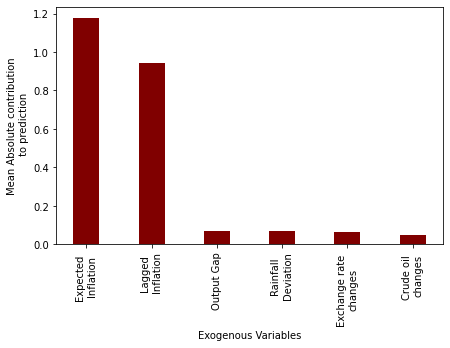

In [125]:
plt.bar("vars", "shap", data = df2, color ='maroon',
        width = 0.4)
plt.tight_layout()

plt.ylabel("Mean Absolute contribution\n to prediction")
plt.xlabel("Exogenous Variables")
plt.xticks(rotation = 90)

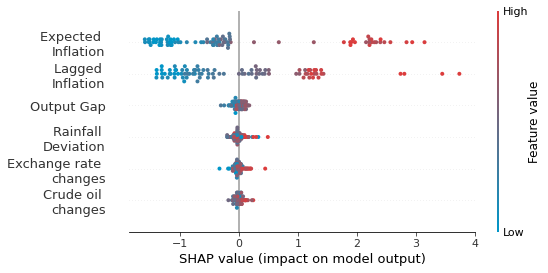

In [126]:
RGB_val = 255

color01= (0,150,200)  # Blue wanted
color04= (220,60,60)  # red wanted
Colors = [color01, color04]

# Creating a blue red palette transition for graphics
Colors= [(R/RGB_val,G/RGB_val,B/RGB_val) for idx, (R,G,B) in enumerate(Colors)]
n = 256

# Start of the creation of the gradient
Color01= ListedColormap(Colors[0], name='Color01', N=None)
Color04= ListedColormap(Colors[1], name='Color04', N=None)
top = cm.get_cmap(Color01,128)
bottom = cm.get_cmap(Color04,128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))

mymin0 = newcolors[0][0]
mymin1 = newcolors[0][1]
mymin2 = newcolors[0][2]
mymin3 = newcolors[0][3]
mymax0 = newcolors[255][0]
mymax1 = newcolors[255][1]
mymax2 = newcolors[255][2]
mymax3 = newcolors[255][3]

GradientBlueRed= [np.linspace(mymin0, mymax0,  n),
                   np.linspace(mymin1, mymax1,  n),
                   np.linspace(mymin2, mymax2,  n),
                   np.linspace(mymin3, mymax3,  n)]

GradientBlueRed_res =np.transpose(GradientBlueRed)


# Create colormap
newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')

# Plot the summary without showing it
plt.figure(figsize = (8,8))
shap.summary_plot(shap_values.values[:, :], exog_hybrid.iloc[:,:], feature_names=exog_hybrid.columns, show = False)
# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(newcmp)


#shap.summary_plot(shap_values, exog_hybrid2, feature_names=exog_hybrid2.columns, show = False, cmap="RdBl")
plt.tight_layout()
#plt.savefig("Plots/shap_summary.jpg", dpi = 500)

In [127]:
explainer.expected_value

6.229180857770058

In [128]:
shaps = []
for i in range(exog_hybrid.iloc[-24:,:].shape[0]):
    vals = shap_values[i].values
    expected_val = shap_values[i].base_values
    list_of_vals = [i for i in vals]
    shaps.append(list_of_vals)

df_plot = pd.DataFrame(shaps, columns= list(exog_hybrid.columns), index = exog_hybrid.iloc[-24:,:].index)

In [129]:
df_plot['Quarter'] = pd.to_datetime(df_plot.index)
df_plot['Quarter'] = df_plot['Quarter'].dt.strftime('%b-%Y')
df_plot.head()

,Expected \nInflation,Lagged \nInflation,Exchange rate \nchanges,Crude oil \nchanges,Rainfall \nDeviation,Output Gap,Quarter
Quarter,,,,,,,
2017-06-30,-1.442933,-1.308182,-0.067858,-0.097820,-0.120835,0.008356,Jun-2017
2017-09-30,-1.448092,-1.303394,-0.031063,-0.073621,-0.180009,-0.041937,Sep-2017
2017-12-31,-1.175878,-1.077069,0.034889,-0.028452,0.292109,0.021300,Dec-2017
2018-03-31,-1.137036,-0.701997,0.052649,-0.009895,0.012212,0.035904,Mar-2018
2018-06-30,-1.037074,-0.630581,0.063875,0.038962,0.054976,0.064059,Jun-2018


Text(0, 0.5, 'Contribution over\n mean prediction')

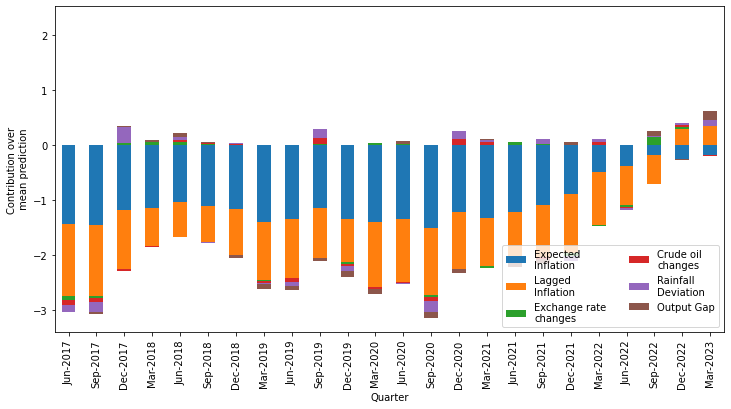

In [130]:
df_plot.plot(x = 'Quarter', kind = 'bar', stacked = True, figsize = (12,6))
plt.plot(exog_hybrid.iloc[-24:,:].index, (target[-24:] - target[-24:].mean()))
#plt.hlines(y = 0, xmin = exog_hybrid.index[0], xmax = exog_hybrid.index[-1], color = 'k', ls = '--')
plt.legend(ncol=2, loc='lower right')#, bbox_to_anchor=(1.01, 1))
plt.ylabel("Contribution over\n mean prediction")

#plt.savefig("Plots/hist_decomp.jpg", dpi = 500, bbox_inches='tight')

In [ ]:

for i,col in enumerate(list(exog_hybrid.columns)):
    
    fig, axs = plt.subplots(figsize=(4,4))
    axs.set_ylim(-1,1)
    img = PartialDependenceDisplay.from_estimator(rf_model, exog_hybrid, features = [col], kind='both', ax = axs, centered=True, ice_lines_kw={"color": "blue", "alpha": 0.3, 'label':'Individual Effects'}, pd_line_kw={"color": "black","lw":3,'linestyle':'--', 'label':'Mean Effect'}, grid_resolution=10)

    fig.tight_layout()

    #plt.savefig("Plots/" + str(i) + ".jpg", dpi = 500)

In [ ]:
from PyALE import ale
from alepython import ale_plot

for i,col in enumerate(list(exog_hybrid.columns)):

    figs,axs = plt.subplots(figsize=(4,4))
    axs.set_xlim(-2,2)
    ales = ale(X=exog_hybrid, model=rf_model, feature=[col], feature_type="continuous", grid_size=4, include_CI=True, fig = figs, ax = axs, C = 0.9)
    
    
    #figs.savefig("Plots/ale" + str(i) + ".jpg", bbox_inches='tight', dpi = 300)

### Consolidated explanations (Used in the paper)

In [7]:
data = pd.read_excel('Quarterly PC.xlsx', sheet_name = "base", index_col="Quarter")#.loc[:"2016"]
data = data.dropna()
#data = data.drop("2020-09-30", axis = 0)
data.tail()

,LGDP_SA,Inflation,Crude_YoY,FX_YoY,Rainfall_YoY,GDP_YoY,Spread
Quarter,,,,,,,
2022-03-31,6.583204,6.344475,23.425214,-0.389598,-2.6,3.958153,0.355913
2022-06-30,6.604842,7.278415,13.955013,-2.589443,7.5,13.084520,-0.399106
2022-09-30,6.596149,7.040524,-12.422674,-3.207663,69.5,6.198306,-1.098298
2022-12-31,6.597467,6.140879,-11.582914,-2.909523,23.0,4.462819,-1.396664
2023-03-31,6.607603,6.206206,-7.285191,-0.069313,-17.8,6.058686,-1.599543


In [8]:
def fit_unobserved_components_model(data, column):
    """Fit an unobserved components model."""
    unrestricted_model = {
        'level': 'local linear trend',
        'cycle': True,
        'damped_cycle': True,
        'stochastic_cycle': True
    }
    mod = sm.tsa.UnobservedComponents(data[column], **unrestricted_model)
    res = mod.fit(method='powell', disp=False)
    return res


def fit_hpfilter(data, column):
    cycle, trend = hpfilter(data[column], lamb=1600)

    return {'cycle': cycle,
            'trend':trend}
    
data['ogap'] = fit_unobserved_components_model(data, "LGDP_SA").cycle["smoothed"]*100
data['trend_inf'] = fit_unobserved_components_model(data, "Inflation").level["smoothed"]
data['exp_inf_ahead'] = data['trend_inf'].shift(1)
data['Inf_lag_1'] = data['Inflation'].shift(1)

for lag in range(1, 5):
    for col in ['FX_YoY', 'Crude_YoY', 'Rainfall_YoY', 'ogap']:
        data[f'{col}_lag_{lag}'] = data[col].shift(lag)

data = data.dropna()
data.tail()

,LGDP_SA,Inflation,Crude_YoY,FX_YoY,Rainfall_YoY,GDP_YoY,Spread,ogap,trend_inf,exp_inf_ahead,...,Rainfall_YoY_lag_2,ogap_lag_2,FX_YoY_lag_3,Crude_YoY_lag_3,Rainfall_YoY_lag_3,ogap_lag_3,FX_YoY_lag_4,Crude_YoY_lag_4,Rainfall_YoY_lag_4,ogap_lag_4
Quarter,,,,,,,,,,,,,,,,,,,,,
2022-03-31,6.583204,6.344475,23.425214,-0.389598,-2.6,3.958153,0.355913,-0.205293,6.177344,6.046898,...,-21.6,0.093452,-1.144902,13.073132,57.42,-0.883531,1.176359,35.871585,-23.89,0.992787
2022-06-30,6.604842,7.278415,13.955013,-2.589443,7.5,13.084520,-0.399106,0.938293,6.293807,6.177344,...,53.9,0.027694,-0.484793,6.858781,-21.60,0.093452,-1.144902,13.073132,57.42,-0.883531
2022-09-30,6.596149,7.040524,-12.422674,-3.207663,69.5,6.198306,-1.098298,-0.141216,6.385267,6.293807,...,-2.6,-0.205293,-1.156781,9.256416,53.90,0.027694,-0.484793,6.858781,-21.60,0.093452
2022-12-31,6.597467,6.140879,-11.582914,-2.909523,23.0,4.462819,-1.396664,-0.364077,6.461850,6.385267,...,7.5,0.938293,-0.389598,23.425214,-2.60,-0.205293,-1.156781,9.256416,53.90,0.027694
2023-03-31,6.607603,6.206206,-7.285191,-0.069313,-17.8,6.058686,-1.599543,-0.006742,6.555529,6.461850,...,69.5,-0.141216,-2.589443,13.955013,7.50,0.938293,-0.389598,23.425214,-2.60,-0.205293


In [9]:
target = data['Inflation']
#exog_hybrid = data.iloc[:, [2,3,4,9,10,14]]
exog_hybrid = data.iloc[:, [2,3,4,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]]
#exog_hybrid.columns = ['Crude oil \nchanges',  'Exchange rate \nchanges',
#                       'Rainfall \nDeviation', 'Expected \nInflation',
#                       'Lagged \nInflation', 'Lagged Output \nGap']

exog_hybrid.columns = ['Crude oil \nchanges', 'Exchange rate \nchanges', 'Rainfall \nDeviation', 'Expected \nInflation', 'Lagged \nInflation',
       'Exchange rate \nchanges L1', 'Crude oil \nchanges L1', 'Rainfall \nDeviation L1', 'Lagged Output \nGap L1',
       'Exchange rate \nchanges L2', 'Crude oil \nchanges L2', 'Rainfall \nDeviation L2', 'Lagged Output \nGap L2',
       'Exchange rate \nchanges L3', 'Crude oil \nchanges L3', 'Rainfall \nDeviation L3', 'Lagged Output \nGap L3',
       'Exchange rate \nchanges L4', 'Crude oil \nchanges L4', 'Rainfall \nDeviation L4', 'Lagged Output \nGap L4']
exog_hybrid.columns

Index(['Crude oil \nchanges', 'Exchange rate \nchanges',
       'Rainfall \nDeviation', 'Expected \nInflation', 'Lagged \nInflation',
       'Exchange rate \nchanges L1', 'Crude oil \nchanges L1',
       'Rainfall \nDeviation L1', 'Lagged Output \nGap L1',
       'Exchange rate \nchanges L2', 'Crude oil \nchanges L2',
       'Rainfall \nDeviation L2', 'Lagged Output \nGap L2',
       'Exchange rate \nchanges L3', 'Crude oil \nchanges L3',
       'Rainfall \nDeviation L3', 'Lagged Output \nGap L3',
       'Exchange rate \nchanges L4', 'Crude oil \nchanges L4',
       'Rainfall \nDeviation L4', 'Lagged Output \nGap L4'],
      dtype='object')

In [10]:
#X_train, X_test, y_train, y_test = train_test_split(exog_hybrid, target, test_size=0.5, random_state=41, shuffle = False)

In [11]:
## optimizing RF
"""
model_rf = RandomForestRegressor(random_state = 42)
rf_param_grid = {
                'n_estimators': [50, 100, 150],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5, 8]
            }
rf_grid = GridSearchCV(model_rf, rf_param_grid, cv=5)
rf_grid.fit(exog_hybrid, target)
model_rf = rf_grid.best_estimator_
print(model_rf)
"""


"\nmodel_rf = RandomForestRegressor(random_state = 42)\nrf_param_grid = {\n                'n_estimators': [50, 100, 150],\n                'max_depth': [3, 5, 7],\n                'min_samples_split': [2, 5, 8]\n            }\nrf_grid = GridSearchCV(model_rf, rf_param_grid, cv=5)\nrf_grid.fit(exog_hybrid, target)\nmodel_rf = rf_grid.best_estimator_\nprint(model_rf)\n"

In [12]:
import random
random.seed(23)

### using optimised model
rf_model = RandomForestRegressor(max_depth=5, random_state=42).fit(exog_hybrid, target)
lr_model = LinearRegression().fit(exog_hybrid, target)
print(np.round(rf_model.feature_importances_, 3))
print(exog_hybrid.columns)
print(np.round(lr_model.coef_,3))
explainer_rf = shap.TreeExplainer(rf_model, exog_hybrid)
explainer_lr = shap.Explainer(lr_model, exog_hybrid)


shap_values_rf = explainer_rf(exog_hybrid)
shap_values_lr = explainer_lr(exog_hybrid)


absolute_mean_shap_rf = np.abs(shap_values_rf.values).mean(axis = 0)
absolute_mean_shap_lr = np.abs(shap_values_lr.values).mean(axis = 0)

[0.005 0.004 0.006 0.607 0.271 0.007 0.004 0.007 0.003 0.006 0.005 0.009
 0.003 0.002 0.006 0.03  0.005 0.002 0.008 0.005 0.005]
Index(['Crude oil \nchanges', 'Exchange rate \nchanges',
       'Rainfall \nDeviation', 'Expected \nInflation', 'Lagged \nInflation',
       'Exchange rate \nchanges L1', 'Crude oil \nchanges L1',
       'Rainfall \nDeviation L1', 'Lagged Output \nGap L1',
       'Exchange rate \nchanges L2', 'Crude oil \nchanges L2',
       'Rainfall \nDeviation L2', 'Lagged Output \nGap L2',
       'Exchange rate \nchanges L3', 'Crude oil \nchanges L3',
       'Rainfall \nDeviation L3', 'Lagged Output \nGap L3',
       'Exchange rate \nchanges L4', 'Crude oil \nchanges L4',
       'Rainfall \nDeviation L4', 'Lagged Output \nGap L4'],
      dtype='object')
[ 0.005 -0.087  0.002  0.4    0.583  0.014  0.01   0.001 -0.11  -0.03
  0.003 -0.001  0.074 -0.038 -0.004 -0.004  0.131 -0.019 -0.01  -0.001
 -0.1  ]


In [13]:
for i in ['Crude oil changes', 'Exchange rate changes',
       'Rainfall Deviation', 'Expected Inflation', 'Lagged Inflation',
       'Exchange rate changes L1', 'Crude oil changes L1',
       'Rainfall Deviation L1', 'Lagged Output Gap L1',
       'Exchange rate changes L2', 'Crude oil changes L2',
       'Rainfall Deviation L2', 'Lagged Output Gap L2',
       'Exchange rate changes L3', 'Crude oil changes L3',
       'Rainfall Deviation L3', 'Lagged Output Gap L3',
       'Exchange rate changes L4', 'Crude oil changes L4',
       'Rainfall Deviation L4', 'Lagged Output Gap L4']:
    print(i)

Crude oil changes
Exchange rate changes
Rainfall Deviation
Expected Inflation
Lagged Inflation
Exchange rate changes L1
Crude oil changes L1
Rainfall Deviation L1
Lagged Output Gap L1
Exchange rate changes L2
Crude oil changes L2
Rainfall Deviation L2
Lagged Output Gap L2
Exchange rate changes L3
Crude oil changes L3
Rainfall Deviation L3
Lagged Output Gap L3
Exchange rate changes L4
Crude oil changes L4
Rainfall Deviation L4
Lagged Output Gap L4


In [14]:
#clust = shap.utils.hclust(exog_hybrid, target, linkage="single")
#shap.plots.bar(shap_values_rf, clustering=clust, clustering_cutoff=1)

In [15]:
mean_abs_shap_val = pd.DataFrame(
   dict(
      vars= exog_hybrid.columns,
      shap_rf= absolute_mean_shap_rf,
      shap_lr = absolute_mean_shap_lr
   )
)
mean_abs_shap_val =np.round(mean_abs_shap_val.sort_values(by = "shap_rf", ascending = False), 4)

##### Permutation Importance

In [16]:
from sklearn.inspection import permutation_importance

result_rf = permutation_importance(rf_model, exog_hybrid, target, n_repeats=5, random_state=42)
result_lr = permutation_importance(lr_model, exog_hybrid, target, n_repeats=5, random_state=42)

In [17]:
# Print the feature importance scores
perm_imp_rf = []
perm_imp_lr = []
for i in range(len(result_rf.importances_mean)):
    perm_imp_rf.append(np.round(result_rf.importances_mean[i],3))
    perm_imp_lr.append(np.round(result_lr.importances_mean[i],3))

data_perm_imp = pd.DataFrame(zip(perm_imp_rf, perm_imp_lr))
data_perm_imp.columns = ["perm_rf", "perm_lr"]
data_perm_imp["vars"] = exog_hybrid.columns
data_perm_imp = data_perm_imp.sort_values(by="perm_rf", ascending=False)

In [18]:
## Combined importances

merged_importances = pd.merge(left = mean_abs_shap_val, right = data_perm_imp, on = "vars")
merged_importances

,vars,shap_rf,shap_lr,perm_rf,perm_lr
0,Expected \nInflation,1.3901,0.8179,0.955,0.250
1,Lagged \nInflation,0.6532,1.2862,0.223,0.712
2,Rainfall \nDeviation L3,0.0700,0.1356,0.029,0.013
3,Rainfall \nDeviation,0.0456,0.0627,0.007,0.004
4,Lagged Output \nGap L3,0.0319,0.0405,0.004,0.001
5,Rainfall \nDeviation L2,0.0303,0.0487,0.005,0.001
6,Rainfall \nDeviation L4,0.0225,0.0373,0.003,0.001
7,Crude oil \nchanges L4,0.0220,0.1080,0.005,0.007
8,Exchange rate \nchanges L2,0.0217,0.0648,0.003,0.004
9,Exchange rate \nchanges L1,0.0213,0.0302,0.004,0.001


In [19]:
import seaborn as sns

In [20]:
df_shap = merged_importances.iloc[:,0:3]
df_perm = merged_importances.iloc[:,[0,3,4]]

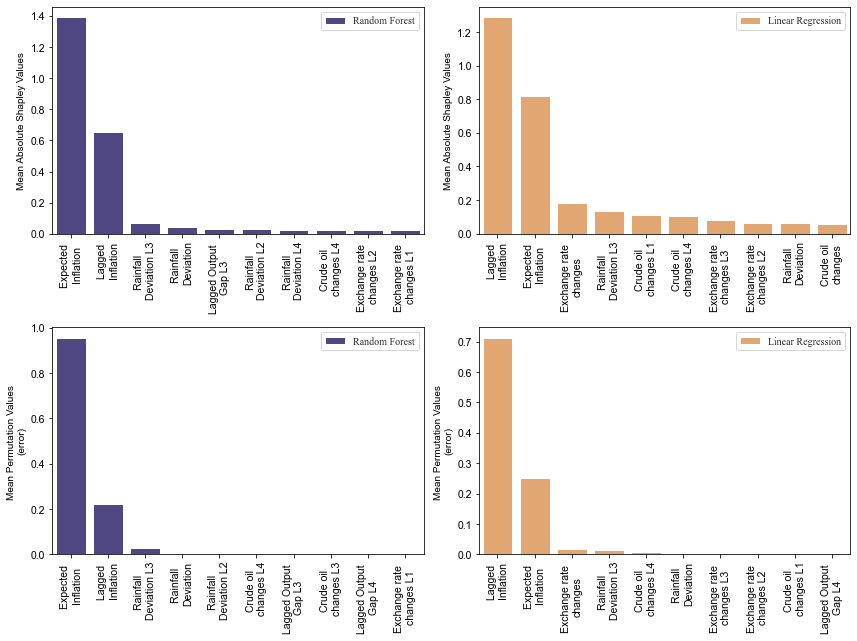

In [21]:
fig,axes = plt.subplots(2,2,figsize = (12,9), sharex = False, sharey = False)

sns.set_theme(style="white", font_scale=0.8, font="Times New Roman")

# Color palette
colors = {'Random Forest': 'darkslateblue', 'Linear Regression': 'sandybrown'}

sns.barplot(ax=axes[0,0], x='vars', y='shap_rf', data=df_shap.sort_values(by = 'shap_rf', ascending = False).iloc[:10,:], 
             label='Random Forest', color=colors['Random Forest'])
axes[0,0].set_ylabel('Mean Absolute Shapley Values', fontsize=10)
axes[0,0].set_xlabel('', fontsize=10)
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=90, ha='center')
axes[0,0].tick_params(axis='both', which='major', labelsize=10.5)

sns.barplot(ax=axes[0,1], x='vars', y='shap_lr', data=df_shap.sort_values(by = 'shap_lr', ascending = False).iloc[:10,:], 
             label='Linear Regression', color=colors['Linear Regression'])
axes[0,1].set_ylabel('Mean Absolute Shapley Values', fontsize=10)
axes[0,1].set_xlabel('', fontsize=10)
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=90, ha='center')
axes[0,1].tick_params(axis='both', which='major', labelsize=10.5)

sns.barplot(ax=axes[1,0], x='vars', y='perm_rf', data=df_perm.sort_values(by = 'perm_rf', ascending = False).iloc[:10,:], 
             label='Random Forest', color=colors['Random Forest'])
axes[1,0].set_ylabel('Mean Permutation Values \n(error)', fontsize=10)
axes[1,0].set_xlabel('', fontsize=10)
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=90, ha='center')
axes[1,0].tick_params(axis='both', which='major', labelsize=10.5)

sns.barplot(ax=axes[1,1], x='vars', y='perm_lr', data=df_perm.sort_values(by = 'perm_lr', ascending = False).iloc[:10,:],
            label='Linear Regression', color=colors['Linear Regression'])
axes[1,1].set_ylabel('Mean Permutation Values \n(error)', fontsize=10)
axes[1,1].set_xlabel('', fontsize=10)
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=90, ha='center')
axes[1,1].tick_params(axis='both', which='major', labelsize=10.5)

axes[0,0].legend(fontsize = 10)
axes[0,1].legend(fontsize = 10)
axes[1,0].legend(fontsize = 10)
axes[1,1].legend(fontsize = 10)

plt.tight_layout()

#plt.savefig("Plots/Variable_importance.jpg", bbox_inches = "tight", dpi = 800)


In [22]:
#X_test.shape

In [23]:
shap_vals_rf = pd.DataFrame(shap_values_rf.values, index = exog_hybrid.index, columns = exog_hybrid.columns)
shap_vals_lr = pd.DataFrame(shap_values_lr.values, index = exog_hybrid.index, columns = exog_hybrid.columns)

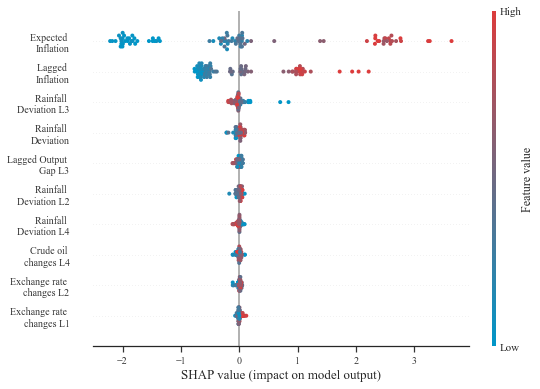

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import shap

RGB_val = 255

color01 = (0, 150, 200)  # Blue wanted
color04 = (220, 60, 60)  # Red wanted
Colors = [color01, color04]

# Creating a blue red palette transition for graphics
Colors = [(R/RGB_val, G/RGB_val, B/RGB_val) for idx, (R, G, B) in enumerate(Colors)]
n = 256

# Start of the creation of the gradient
Color01 = ListedColormap(Colors[0], name='Color01', N=None)
Color04 = ListedColormap(Colors[1], name='Color04', N=None)
top = plt.get_cmap(Color01, 128)
bottom = plt.get_cmap(Color04, 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))

mymin0 = newcolors[0][0]
mymin1 = newcolors[0][1]
mymin2 = newcolors[0][2]
mymin3 = newcolors[0][3]
mymax0 = newcolors[255][0]
mymax1 = newcolors[255][1]
mymax2 = newcolors[255][2]
mymax3 = newcolors[255][3]

GradientBlueRed = [np.linspace(mymin0, mymax0, n),
                   np.linspace(mymin1, mymax1, n),
                   np.linspace(mymin2, mymax2, n),
                   np.linspace(mymin3, mymax3, n)]

GradientBlueRed_res = np.transpose(GradientBlueRed)

# Create colormap
newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')

# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values_rf.values), axis=0)
top_10_indices = np.argsort(mean_abs_shap_values)[-10:]

# Plot the top 10 features
#plt.figure(figsize=(12, 7))
shap.summary_plot(shap_values_rf.values[:, top_10_indices], exog_hybrid.iloc[:, top_10_indices], feature_names=exog_hybrid.columns[top_10_indices], show=False)
plt.tick_params(labelsize=10)

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(newcmp)

plt.tight_layout()
#plt.savefig("Plots/shap_summary.jpg", dpi=500)


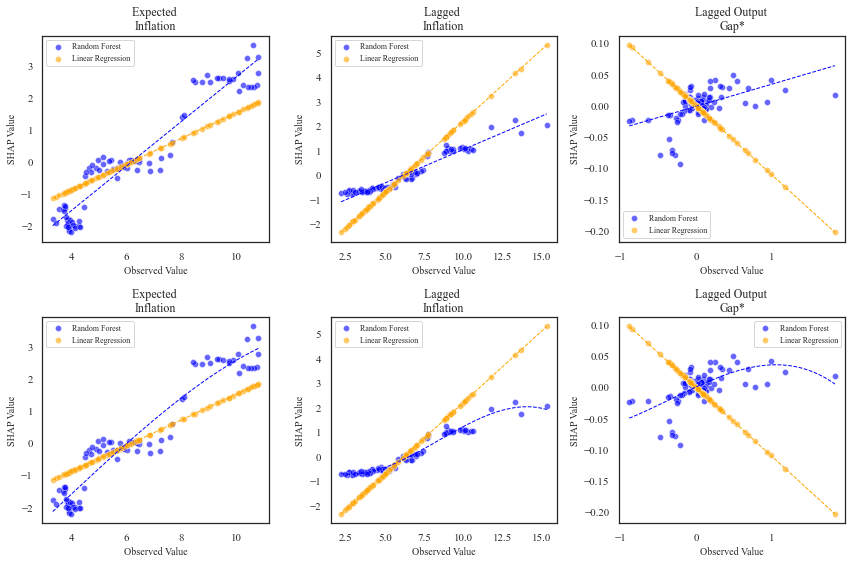

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming shap_vals_rf, shap_vals_lr, and exog_hybrid are already defined
features = ['Expected \nInflation', 'Lagged \nInflation', 'Lagged Output \nGap L1']

# Set up the plot
sns.set_theme(style="white", font_scale=1.0, font="Times New Roman")
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, feature in enumerate(features):
    for j, order in enumerate([1, 3]):  # Order 1 for top row, Order 3 for bottom row
        # Create DataFrames for each model and feature
        if feature == 'Lagged Output \nGap L1':
            # Filter out the specific date for the output gap plot
            mask = exog_hybrid.index != '2020-09-30'
            df_rf = pd.DataFrame({
                'SHAP Value': shap_vals_rf[feature][mask],
                'Observed Value': exog_hybrid[feature][mask],
                'Model': 'Random Forest'
            })
            df_lr = pd.DataFrame({
                'SHAP Value': shap_vals_lr[feature][mask],
                'Observed Value': exog_hybrid[feature][mask],
                'Model': 'Linear Regression'
            })
        else:
            df_rf = pd.DataFrame({
                'SHAP Value': shap_vals_rf[feature],
                'Observed Value': exog_hybrid[feature],
                'Model': 'Random Forest'
            })
            df_lr = pd.DataFrame({
                'SHAP Value': shap_vals_lr[feature],
                'Observed Value': exog_hybrid[feature],
                'Model': 'Linear Regression'
            })

        # Combine the DataFrames
        df_combined = pd.concat([df_rf, df_lr])

        # Create the scatter plot
        sns.scatterplot(data=df_rf, y='SHAP Value', x='Observed Value', ax=axes[j, i], color='blue', alpha=0.6, label='Random Forest')
        sns.scatterplot(data=df_lr, y='SHAP Value', x='Observed Value', ax=axes[j, i], color='orange', alpha=0.6, label='Linear Regression')

        # Add regression lines
        sns.regplot(data=df_rf, y='SHAP Value', x='Observed Value', ax=axes[j, i], scatter=False, color='blue', line_kws={'linewidth': 1, "ls": '--'}, order=order, ci=None)
        sns.regplot(data=df_lr, y='SHAP Value', x='Observed Value', ax=axes[j, i], scatter=False, color='orange', line_kws={'linewidth': 1, "ls": '--'}, order=order, ci=None)

        if feature == 'Lagged Output \nGap L1':
            axes[j, i].set_title(f"Lagged Output \nGap*", fontsize=12)
        else:
            axes[j, i].set_title(f"{feature}", fontsize=12)
        
        axes[j, i].grid(False)
        axes[j, i].set_xlabel('Observed Value', fontsize=10)
        axes[j, i].set_ylabel('SHAP Value', fontsize=10)

        # Show legend on all subplots
        axes[j, i].legend(fontsize=8)

# Adjust layout and show plot
plt.tight_layout()
# Uncomment the following line to save the figure
#plt.savefig("Plots/learned_functional_form.jpg", dpi=800, bbox_inches="tight")

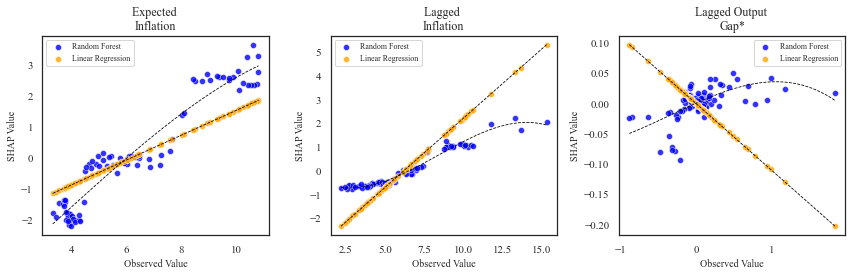

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming shap_vals_rf, shap_vals_lr, and exog_hybrid are already defined
features = ['Expected \nInflation', 'Lagged \nInflation', 'Lagged Output \nGap L1']

# Set up the plot
sns.set_theme(style="white", font_scale=1.0, font="Times New Roman")
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, feature in enumerate(features):
    # Create DataFrames for each model and feature
    if feature == 'Lagged Output \nGap L1':
        # Filter out the specific date for the output gap plot
        mask = exog_hybrid.index != '2020-09-30'
        df_rf = pd.DataFrame({
            'SHAP Value': shap_vals_rf[feature][mask],
            'Observed Value': exog_hybrid[feature][mask],
            'Model': 'Random Forest'
        })
        df_lr = pd.DataFrame({
            'SHAP Value': shap_vals_lr[feature][mask],
            'Observed Value': exog_hybrid[feature][mask],
            'Model': 'Linear Regression'
        })
    else:
        df_rf = pd.DataFrame({
            'SHAP Value': shap_vals_rf[feature],
            'Observed Value': exog_hybrid[feature],
            'Model': 'Random Forest'
        })
        df_lr = pd.DataFrame({
            'SHAP Value': shap_vals_lr[feature],
            'Observed Value': exog_hybrid[feature],
            'Model': 'Linear Regression'
        })

    # Combine the DataFrames
    df_combined = pd.concat([df_rf, df_lr])

    # Create the scatter plot
    sns.scatterplot(data=df_rf, y='SHAP Value', x='Observed Value', ax=axes[i], color='blue', alpha=0.8, label='Random Forest')
    sns.scatterplot(data=df_lr, y='SHAP Value', x='Observed Value', ax=axes[i], color='orange', alpha=0.8, label='Linear Regression')

    # Add 3rd-order regression lines
    sns.regplot(data=df_rf, y='SHAP Value', x='Observed Value', ax=axes[i], scatter=False, color='black', line_kws={'linewidth': 0.8, "ls": '--'}, order=3, ci=None)
    sns.regplot(data=df_lr, y='SHAP Value', x='Observed Value', ax=axes[i], scatter=False, color='black', line_kws={'linewidth': 0.8, "ls": '--'}, order=3, ci=None)

    if feature == 'Lagged Output \nGap L1':
        axes[i].set_title(f"Lagged Output \nGap*", fontsize=12)
    else:
        axes[i].set_title(f"{feature}", fontsize=12)
    
    axes[i].grid(False)
    axes[i].set_xlabel('Observed Value', fontsize=10)
    axes[i].set_ylabel('SHAP Value', fontsize=10)

    # Show legend on each subplot
    axes[i].legend(fontsize=8)

# Adjust layout and show plot
plt.tight_layout()
# Uncomment the following line to save the figure
#plt.savefig("Plots/learned_functional_form_only3order.jpg", dpi=800, bbox_inches="tight")
#plt.show()


#### PDP plots

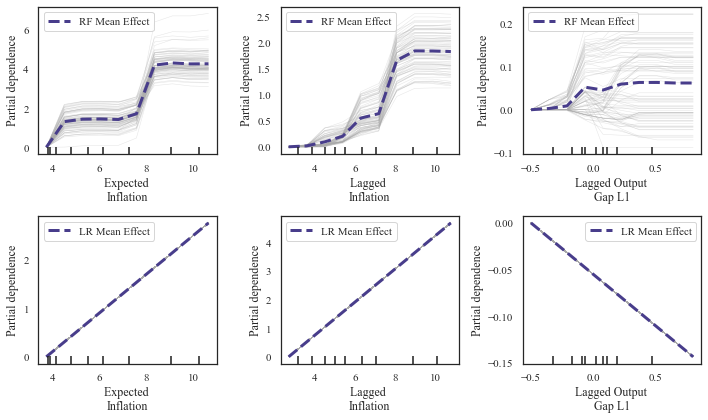

In [30]:
# Create a 2x3 grid for 1D PDPs
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# Define features and combinations
features = ['Expected \nInflation', 'Lagged \nInflation', 'Lagged Output \nGap L1']
combinations = [
    ('Expected \nInflation', 'Lagged \nInflation'),
    ('Lagged Output \nGap L1', 'Expected \nInflation'),
    ('Lagged Output \nGap L1','Lagged \nInflation')
]

# Plot the top row with 1D PDPs for the Random Forest model
for i, col in enumerate(features):
    ax = axs[0, i]
    display_rf = PartialDependenceDisplay.from_estimator(
        rf_model, exog_hybrid, features=[col], kind='both', ax=ax, centered=True,
        ice_lines_kw={"color": "darkgrey", "alpha": 0.3, 'label': 'RF Individual Effects'},
        pd_line_kw={"color": "darkslateblue", "lw": 3, 'linestyle': '--', 'label': 'RF Mean Effect'},
        grid_resolution=10
    )
    ax.set_xlabel(f'Custom X label for {col}')  # Set custom x-axis label
    ax.set_ylabel('Custom Y label')  # Set custom y-axis label

# Plot the bottom row with 1D PDPs for the Linear Regression model
for i, col in enumerate(features):
    ax = axs[1, i]
    display_lr = PartialDependenceDisplay.from_estimator(
        lr_model, exog_hybrid, features=[col], kind='both', ax=ax, centered=True,
        ice_lines_kw={"color": "darkgrey", "alpha": 0.3, 'label': 'RF Individual Effects'},
        pd_line_kw={"color": "darkslateblue", "lw": 3, 'linestyle': '--', 'label': 'LR Mean Effect'},
        grid_resolution=10
    )
    ax.set_xlabel(f'Custom X label for {col}')  # Set custom x-axis label
    ax.set_ylabel('Custom Y label')  # Set custom y-axis label

# Adjust layout for the first grid
plt.tight_layout()
#plt.savefig('Plots/1d-pdp.jpg', dpi = 800, bbox_inches = "tight")


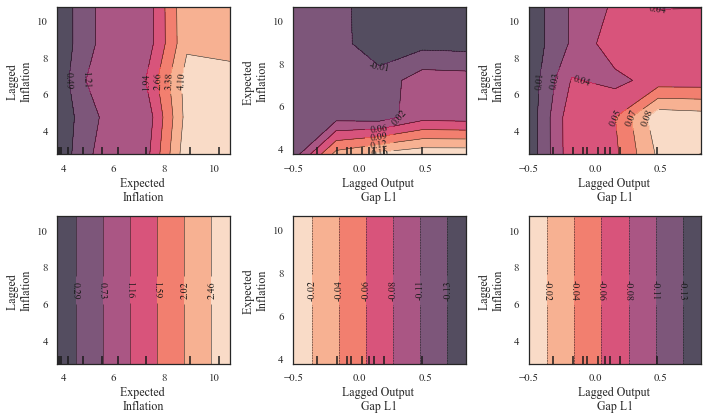

In [32]:
# Create a 2x3 grid for 2D PDPs (for both Random Forest and Linear Regression)
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# Plot 2D PDPs for each pair of features
for i, (feature_1, feature_2) in enumerate(combinations):
    # Top row for Random Forest
    ax_rf = axs[0, i]
    display_rf = PartialDependenceDisplay.from_estimator(
        rf_model, exog_hybrid, features=[(feature_1, feature_2)], ax=ax_rf,
        grid_resolution=5, centered=True,
        pd_line_kw={"color": "darkslateblue", "lw": 3, 'linestyle': '--', 'label': 'RF Mean Effect'},
        ice_lines_kw={"color": "darkgrey", "alpha": 0.3}
    )
    ax_rf.set_xlabel(f'Custom X label for {feature_1}')  # Set custom x-axis label
    ax_rf.set_ylabel(f'Custom Y label for {feature_2}')  # Set custom y-axis label

    # Bottom row for Linear Regression
    ax_lr = axs[1, i]
    display_lr = PartialDependenceDisplay.from_estimator(
        lr_model, exog_hybrid, features=[(feature_1, feature_2)], ax=ax_lr,
        grid_resolution=5, centered=True,
        pd_line_kw={"color": "darkorange", "lw": 3, 'linestyle': '-', 'label': 'LR Mean Effect'}
    )
    ax_lr.set_xlabel(f'Custom X label for {feature_1}')  # Set custom x-axis label
    ax_lr.set_ylabel(f'Custom Y label for {feature_2}')  # Set custom y-axis label

# Adjust layout for the second grid
plt.tight_layout()
#plt.savefig('Plots/2d-pdp.jpg', dpi = 800, bbox_inches = "tight")


#### Shapley Regressions

In [98]:
###create exogenous data

exog_rf = pd.DataFrame(shap_values_rf.values, columns = exog_hybrid.columns, index = exog_hybrid.index)
exog_lr = pd.DataFrame(shap_values_lr.values, columns = exog_hybrid.columns, index = exog_hybrid.index)

In [99]:
shap_reg_rf = sm.OLS(endog = target, exog = sm.add_constant(exog_rf)).fit(cov_type="HAC", cov_kwds = {"maxlags": 3})
shap_reg_lr = sm.OLS(endog = target, exog = sm.add_constant(exog_lr)).fit(cov_type="HAC", cov_kwds = {"maxlags": 3})

In [100]:
shap_reg_rf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Inflation   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2124.
Date:                Sun, 18 Aug 2024   Prob (F-statistic):           2.60e-86
Time:                        23:46:48   Log-Likelihood:                -8.1207
No. Observations:                  89   AIC:                             60.24
Df Residuals:                      67   BIC:                             115.0
Df Model:                          21                                         
Covariance Type:                  HAC                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         6.2684      0.025    250.663      0.000       6.219       6.317
Crude oil 
changes            3.5600      0.954      3.732      0.000       1.691       5.429
Exchange rate 
changes        5.4570      1.670      3.267      0.001       2.184       8.730
Rainfall 
Deviation           1.4223      0.570      2.497      0.013       0.306       2.539
Expected 
Inflation           1.0331      0.044     23.416      0.000       0.947       1.120
Lagged 
Inflation             0.9515      0.091     10.400      0.000       0.772       1.131
Exchange rate 
changes L1     2.3679      1.405      1.685      0.092      -0.386       5.122
Crude oil 
changes L1         2.9400      1.026      2.865      0.004       0.929       4.951
Rainfall 
Deviation L1        2.9487      1.283      2.298      0.022       0.433       5.464
Lagged Output 
Gap L1         0.9376      1.230      0.763      0.446      -1.472       3.347
Exchange rate 
changes L2     1.2296      1.099      1.119      0.263      -0.924       3.383
Crude oil 
changes L2         2.4106      1.235      1.952      0.051      -0.010       4.831
Rainfall 
Deviation L2        1.0097      1.057      0.955      0.339      -1.062       3.082
Lagged Output 
Gap L2         4.6147      2.316      1.992      0.046       0.075       9.155
Exchange rate 
changes L3     1.8446      3.278      0.563      0.574      -4.581       8.270
Crude oil 
changes L3         0.8043      1.573      0.511      0.609      -2.278       3.886
Rainfall 
Deviation L3        1.6213      0.276      5.884      0.000       1.081       2.161
Lagged Output 
Gap L3         1.9576      0.628      3.116      0.002       0.726       3.189
Exchange rate 
changes L4     8.2504      3.772      2.187      0.029       0.857      15.644
Crude oil 
changes L4         1.9340      1.319      1.466      0.143      -0.651       4.519
Rainfall 
Deviation L4        1.3800      1.005      1.374      0.170      -0.589       3.349
Lagged Output 
Gap L4         3.6445      2.389      1.526      0.127      -1.037       8.326
==============================================================================
Omnibus:                        6.442   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                9.418
Skew:                           0.217   Prob(JB):                      0.00901
Kurtosis:                       4.533   Cond. No.                         289.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 3 lags and without small sample correction
"""

In [101]:
shap_reg_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Inflation   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     54.57
Date:                Sun, 18 Aug 2024   Prob (F-statistic):           4.58e-34
Time:                        23:46:49   Log-Likelihood:                -118.82
No. Observations:                  89   AIC:                             281.6
Df Residuals:                      67   BIC:                             336.4
Df Model:                          21                                         
Covariance Type:                  HAC                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         6.2684      0.115     54.651      0.000       6.044       6.493
Crude oil 
changes            1.0000      1.484      0.674      0.500      -1.909       3.909
Exchange rate 
changes        1.0000      0.344      2.906      0.004       0.325       1.675
Rainfall 
Deviation           1.0000      1.207      0.829      0.407      -1.365       3.365
Expected 
Inflation           1.0000      0.228      4.394      0.000       0.554       1.446
Lagged 
Inflation             1.0000      0.134      7.441      0.000       0.737       1.263
Exchange rate 
changes L1     1.0000      3.255      0.307      0.759      -5.380       7.380
Crude oil 
changes L1         1.0000      0.818      1.223      0.221      -0.603       2.603
Rainfall 
Deviation L1        1.0000      2.064      0.485      0.628      -3.045       5.045
Lagged Output 
Gap L1         1.0000      1.317      0.759      0.448      -1.582       3.582
Exchange rate 
changes L2     1.0000      1.599      0.626      0.532      -2.133       4.133
Crude oil 
changes L2         1.0000      3.270      0.306      0.760      -5.410       7.410
Rainfall 
Deviation L2        1.0000      1.531      0.653      0.514      -2.001       4.001
Lagged Output 
Gap L2         1.0000      2.362      0.423      0.672      -3.629       5.629
Exchange rate 
changes L3     1.0000      0.756      1.323      0.186      -0.482       2.482
Crude oil 
changes L3         1.0000      1.901      0.526      0.599      -2.727       4.727
Rainfall 
Deviation L3        1.0000      0.603      1.659      0.097      -0.182       2.182
Lagged Output 
Gap L3         1.0000      1.582      0.632      0.527      -2.100       4.100
Exchange rate 
changes L4     1.0000      1.655      0.604      0.546      -2.243       4.243
Crude oil 
changes L4         1.0000      0.958      1.044      0.297      -0.878       2.878
Rainfall 
Deviation L4        1.0000      2.270      0.440      0.660      -3.450       5.450
Lagged Output 
Gap L4         1.0000      1.249      0.800      0.423      -1.449       3.449
==============================================================================
Omnibus:                        0.160   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.923   Jarque-Bera (JB):                0.124
Skew:                          -0.085   Prob(JB):                        0.940
Kurtosis:                       2.933   Cond. No.                         61.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 3 lags and without small sample correction
"""

In [104]:
from stargazer.stargazer import Stargazer

# Combine results with Stargazer
stargazer = Stargazer([shap_reg_rf])

# Customize the table
stargazer.title("Regression Results")
stargazer.custom_columns(["Random Forest Model"], [1])
stargazer.show_degrees_of_freedom(False)
stargazer.show_model_numbers(False)



#### Train-test split

In [12]:
np.random.seed(42)
data = pd.read_excel('Quarterly PC.xlsx', sheet_name = "base", index_col="Quarter")#.loc[:"2016"]
data = data.dropna()
#data = data.drop(["2020-06-30","2021-03-31"], axis = 0)
data.tail()
def fit_unobserved_components_model(data, column):
    """Fit an unobserved components model."""
    unrestricted_model = {
        'level': 'local linear trend',
        'cycle': True,
        'damped_cycle': True,
        'stochastic_cycle': True
    }
    mod = sm.tsa.UnobservedComponents(data[column], **unrestricted_model)
    res = mod.fit(method='powell', disp=False)
    return res


def fit_hpfilter(data, column):
    cycle, trend = hpfilter(data[column], lamb=1600)

    return {'cycle': cycle,
            'trend':trend}
    
data['ogap'] = fit_unobserved_components_model(data, "LGDP_SA").cycle["smoothed"]*100
data['trend_inf'] = fit_unobserved_components_model(data, "Inflation").level["smoothed"]
data['exp_inf_ahead'] = data['trend_inf'].shift(1)
data['Inf_lag_1'] = data['Inflation'].shift(1)

for lag in range(1, 5):
    for col in ['FX_YoY', 'Crude_YoY', 'Rainfall_YoY', 'ogap']:
        data[f'{col}_lag_{lag}'] = data[col].shift(lag)

data = data.dropna()
data.tail()
target = data['Inflation']
#exog_hybrid = data.iloc[:, [2,3,4,9,10,14]]
#exog_hybrid = data.iloc[:, [2,9,10,22]]
"""
exog_hybrid.columns = ['Crude oil \nchanges',  'Exchange rate \nchanges',
                       'Rainfall \nDeviation', 'Expected \nInflation',
                       'Lagged \nInflation', 'Lagged Output \nGap']
#exog_hybrid.columns = ['Crude oil \nchanges', 'Expected \nInflation',
#                       'Lagged \nInflation', 'Lagged Output \nGap']
"""
exog_hybrid = data.iloc[:, [2,3,4,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]]
#exog_hybrid.columns = ['Crude oil \nchanges',  'Exchange rate \nchanges',
#                       'Rainfall \nDeviation', 'Expected \nInflation',
#                       'Lagged \nInflation', 'Lagged Output \nGap']

exog_hybrid.columns = ['Crude oil \nchanges', 'Exchange rate \nchanges', 'Rainfall \nDeviation', 'Expected \nInflation', 'Lagged \nInflation',
       'Exchange rate \nchanges L1', 'Crude oil \nchanges L1', 'Rainfall \nDeviation L1', 'Lagged Output \nGap L1',
       'Exchange rate \nchanges L2', 'Crude oil \nchanges L2', 'Rainfall \nDeviation L2', 'Lagged Output \nGap L2',
       'Exchange rate \nchanges L3', 'Crude oil \nchanges L3', 'Rainfall \nDeviation L3', 'Lagged Output \nGap L3',
       'Exchange rate \nchanges L4', 'Crude oil \nchanges L4', 'Rainfall \nDeviation L4', 'Lagged Output \nGap L4']
exog_hybrid.columns
exog_hybrid.columns

X_train, X_test, y_train, y_test = train_test_split(exog_hybrid, target, test_size=0.27, random_state=41, shuffle = False)

## optimizing RF

#model_rf = RandomForestRegressor(random_state = 42)
#rf_param_grid = {
#                'n_estimators': [50, 100, 150, 200],
#                'max_depth': [3, 5, 7, 9],
#                'min_samples_split': [2, 3, 5, 7]
#            }
#rf_grid = GridSearchCV(model_rf, rf_param_grid, cv=20)
#rf_grid.fit(X_test, y_test)
#model_rf = rf_grid.best_estimator_
#print(model_rf)


#import random
#random.seed(23)

### using optimised model
#rf_model = RandomForestRegressor(max_depth=3, min_samples_split=8, n_estimators=50,
#                      random_state=42).fit(X_train, y_train)
rf_model = RandomForestRegressor(max_depth=3, n_estimators=50, random_state=42).fit(X_train, y_train)
lr_model = LinearRegression().fit(X_train, y_train)
print(np.round(lr_model.coef_,3))
explainer_rf = shap.TreeExplainer(rf_model, X_test)
explainer_lr = shap.LinearExplainer(lr_model, X_test)


shap_values_rf = explainer_rf(X_test)
shap_values_lr = explainer_lr(X_test)


shap_vals_rf = pd.DataFrame(shap_values_rf.values, index = X_test.index, columns = X_test.columns)
shap_vals_lr = pd.DataFrame(shap_values_lr.values, index = X_test.index, columns = X_test.columns)
#### Shapley Regressions
###create exogenous data

exog_rf = pd.DataFrame(shap_vals_rf.values, columns = X_test.columns, index = X_test.index)
exog_lr = pd.DataFrame(shap_vals_lr.values, columns = X_test.columns, index = X_test.index)
shap_reg_rf = sm.OLS(endog = y_test, exog = sm.add_constant(exog_rf)).fit(cov_type="HAC", cov_kwds = {"maxlags": 3})
shap_reg_lr = sm.OLS(endog = y_test, exog = sm.add_constant(exog_lr)).fit(cov_type="HAC", cov_kwds = {"maxlags": 3})
shap_reg_rf.summary()
shap_reg_lr.summary()
from stargazer.stargazer import Stargazer

# Combine results with Stargazer
stargazer = Stargazer([shap_reg_rf, shap_reg_lr])

# Customize the table
stargazer.title("Regression Results")
stargazer.custom_columns(["Random Forest Model", "Linear Regression"], [1, 1])
stargazer.show_degrees_of_freedom(False)
stargazer.show_model_numbers(False)

stargazer

[ 0.003 -0.082 -0.001  0.451  0.516 -0.004  0.017 -0.003  0.5   -0.076
  0.012 -0.003 -0.757 -0.054  0.012 -0.006 -0.359 -0.002 -0.003  0.001
 -0.915]


#### Using core inflation

In [3]:
data = pd.read_excel('Quarterly PC.xlsx', sheet_name ="Core inf", index_col="Quarter")
data = data.dropna()
data.head()
#data["Inflation"] = data["Inflation"].shift(-3)  ## Edit this for Multiperiod ahead forecasts
#data = data.dropna()


def initialize_prediction_matrices(frcst_length):
    """Initialize matrices to store predictions and actual values."""
    models = ['ax', 'ridge', 'lasso', 'rf', 'xgb']#, 'lgb']
    pred_mat = {model: np.zeros((frcst_length, 1)) for model in models}
    actual_mat = {model: np.zeros((frcst_length, 1)) for model in models}
    return pred_mat, actual_mat

def fit_unobserved_components_model(data, column):
    """Fit an unobserved components model."""
    unrestricted_model = {
        'level': 'local linear trend',
        'cycle': True,
        'damped_cycle': True,
        'stochastic_cycle': True
    }
    mod = sm.tsa.UnobservedComponents(data[column], **unrestricted_model)
    res = mod.fit(method='powell', disp=False)
    return res

def prepare_data(data, train_index):
    """Prepare data for model fitting."""
    dat = data.iloc[:train_index + 1, :].copy()
    
    # Fit unobserved components models
    output_res = fit_unobserved_components_model(dat.iloc[:-1, :], 'LGDP_SA')
    inflation_res = fit_unobserved_components_model(dat.iloc[:-1, :], 'Inflation')
    
    # Calculate expected inflation and output gap
    dat['exp_inf'] = list(inflation_res.level["smoothed"]) + [np.nan]
    dat['ogap'] = list(output_res.cycle["smoothed"] * 100) + [np.nan]
    dat['exp_inf_ahead'] = dat['exp_inf'].shift(1)
    
    # Generate lags
    dat['Inf_lag_1'] = dat['Inflation'].shift(1)
    for lag in range(1, 5):
        for col in ['FX_YoY', 'Crude_YoY', 'Rainfall_YoY', 'ogap', 'GDP_YoY', 'Spread']:
            dat[f'{col}_lag_{lag}'] = dat[col].shift(lag)
    
    th = dat.shape[1] - 3 ##threshold to dropnans
    
    return dat.dropna(thresh=th)

def get_train_test(data, spec):
    """Extract features and target from prepared data."""
    dat1 = data#.iloc[:-1, :].dropna()
    if spec=="backward":
        exog = dat1.iloc[:-1, [2,3,4,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]]
        test = dat1.iloc[-1, [2,3,4,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]].values.reshape(1, -1)
    elif spec=="forward":
        exog = dat1.iloc[:-1, [2,3,4,6,9,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]]
        test = dat1.iloc[-1, [2,3,4,6,9,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]].values.reshape(1, -1)
    elif spec=="hybrid":
        exog = dat1.iloc[:-1, [2,3,4,6,9,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]]
        test = dat1.iloc[-1, [2,3,4,6,9,10,11,12,13,14,17,18,19,20,23,24,25,26,29,30,31,32]].values.reshape(1, -1)
    target = dat1["Inflation"].iloc[:-1]
    return exog, target,test
    

def fit_and_predict(model, exog, target, x_test):
    """Fit a model and make predictions."""
    fitted_model = model.fit(exog, target)
    return fitted_model.predict(x_test)

def forecasting_loop(data, train, frcst_length, spec):
    """Main forecasting loop."""
    pred_mat, actual_mat = initialize_prediction_matrices(frcst_length)
    
    for i in range(frcst_length):
        dat = prepare_data(data, train + i)
        actual = dat.iloc[-1, 1]
        exog, target, test = get_train_test(dat, spec)
        
        
        # Fit models and make predictions
        # Initialize models    
    models = {
        'ax': LinearRegression(),
        'ridge': RidgeCV(),
        'lasso': LassoCV(),
        'rf': RandomForestRegressor(random_state=42),
        'xgb': xgb.XGBRegressor(random_state=42)
    }
    
    for i in range(frcst_length):
        dat = prepare_data(data, train + i)
        actual = dat.iloc[-1, 1]
        exog, target, test = get_train_test(dat, spec)
        
        # RF and XGBoost optimization (only in the first pass)
        if i == 0:
            # Random Forest optimization
            rf_param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5, 10]
            }
            rf_grid = GridSearchCV(models['rf'], rf_param_grid, cv=5)
            rf_grid.fit(exog, target)
            models['rf'] = rf_grid.best_estimator_
            
            # XGBoost optimization
            xgb_param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.1, 0.3]
            }
            xgb_grid = GridSearchCV(models['xgb'], xgb_param_grid, cv=5)
            xgb_grid.fit(exog, target)
            models['xgb'] = xgb_grid.best_estimator_
        
        for model_name, model in models.items():
            preds = fit_and_predict(model, exog, target, test)
            pred_mat[model_name][i, :] = preds
            actual_mat[model_name][i, :] = actual
    
    return pred_mat, actual_mat

def main(data, spec):
    T = len(data)
    train = T - 24 ##change this 24 value for multi-period forecasts
    frcst_length = T - train
    
    print(T, train, frcst_length)
    
    pred_mat, actual_mat = forecasting_loop(data, train, frcst_length, spec)
    
    return pred_mat, actual_mat


    

93 69 24
93 69 24
93 69 24


,Linear Regression,Ridge Regression,Lasso Regression,Random Forest,XGBoost,Actual,Random Walk
Quarter,,,,,,,
2017-09-30,4.787642,4.851087,4.725493,4.698126,4.115996,4.361687,4.111935
2017-12-31,4.589619,4.797293,4.637274,4.463986,3.963894,4.882244,4.361687
2018-03-31,4.922868,4.891368,4.953412,4.627560,4.266924,5.170200,4.882244
2018-06-30,6.014150,5.863211,5.393666,5.063871,4.655561,6.277522,5.170200
2018-09-30,5.841934,6.036256,6.077573,5.372853,4.859414,5.971934,6.277522
2018-12-31,5.670058,5.780107,5.804435,5.525450,5.103551,5.853281,5.971934
2019-03-31,6.197268,6.009277,5.810762,5.714517,4.898755,5.223864,5.853281
2019-06-30,5.559840,5.724318,5.608810,5.276814,5.027005,4.282056,5.223864
2019-09-30,4.878429,4.631618,4.614484,4.823137,4.110271,4.328019,4.282056


In [ ]:
specs = ['backward', 'forward', 'hybrid']
mods = ['ax', 'ridge', 'lasso','rf','xgb']

results_h1 = {}
for specf in specs:
    pred_mat, actual_mat = main(data, spec = specf)
    metrics = {}
    for mod in mods:
        metrics[mod] = calculate_metrics(pred_mat[mod], actual_mat[mod])
    results_h1[specf] = metrics
    
# Convert each array to a 1-dimensional array
for key in pred_mat:
    pred_mat[key] = pred_mat[key].flatten()



In [ ]:
# Create the pred_matFrame
chrt = pd.DataFrame(pred_mat)
chrt["Actual"] = actual_mat["ax"].flatten()
chrt.index = data.tail(24).index
chrt.columns = ["Linear Regression","Ridge Regression","Lasso Regression","Random Forest","XGBoost","Actual"]
chrt["Random Walk"] = chrt["Actual"].shift(1)
chrt = chrt.dropna()
chrt

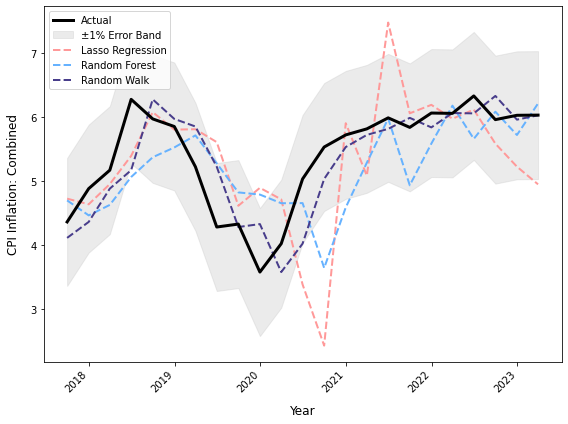

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Set up the plot
plt.figure(figsize=(8,6))
ax = plt.gca()

# Plot actual values with error band
actual_color = '#000000'
error_band_color = 'silver'#'#AAAAAA'
ax.plot(chrt.index, chrt['Actual'], label='Actual', color=actual_color, linewidth=3, zorder=5)

# Calculate and plot ±1% error band for actual values
error = 1  ##acceptable error
ax.fill_between(chrt.index, chrt['Actual'] - error, chrt['Actual'] + error, 
                color=error_band_color, alpha=0.3, label='±1% Error Band')

# Plot forecasted values
models = ['Lasso Regression', 'Random Forest', 'Random Walk']
colors = ['#FF9999', '#66B2FF', 'darkslateblue']

for model, color in zip(models, colors):
    ax.plot(chrt.index, chrt[model], label=f'{model}', color=color, linestyle='--', linewidth=2)

# Customize the plot
#ax.set_title('CPI Inflation: Actual vs Forecasted', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=12, labelpad=10)
ax.set_ylabel('CPI Inflation: Combined', fontsize=12, labelpad=10)

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, ha='right')

# Customize y-axis
#ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Customize legend
ax.legend(title='', fontsize=10, loc='upper left')

# Set background color
#ax.set_facecolor('#F8F8F8')

# Add a subtle border
#for spine in ax.spines.values():
#    spine.set_edgecolor('#CCCCCC')

# Adjust layout and display the plot
plt.tight_layout()
#plt.savefig("Plots/actual_vs_forecast_with_error_band.jpg", bbox_inches='tight', dpi=300)
plt.show()




In [ ]:
#reshaped_df.to_csv('results_updated/horizon2_optim.csv')
#scaled_df = pd.DataFrame()
#for spc in ["backward","forward","hybrid"]:
#    dt = reshaped_df.copy()
#    dt = dt.loc[spc]/dt.loc[spc].max(axis = 0)
#    scaled_df = pd.concat([scaled_df,dt], axis = 0)
    
#scaled_df


In [5]:
##Baseline RW
#actuals = [actual_mat["ax"][i,0] for i in range(21)]
##rw = pd.DataFrame(actuals, index = range(21), columns=['actual'])
#rw['actual_lag'] = rw["actual"].shift(1)
#rw = rw.fillna(4.55470737913486)
#calculate_metrics(rw['actual_lag'], rw['actual'])



In [7]:
from itertools import product

def nested_dict_to_df(data):
    # Flatten the nested dictionary
    flattened = []
    for key1, val1 in data.items():
        for key2, val2 in val1.items():
            for key3, val3 in val2.items():
                flattened.append([key1, key2, key3, val3])
    
    # Create DataFrame
    df = pd.DataFrame(flattened, columns=['Level1', 'Level2', 'Level3', 'Value'])
    
    # Set multi-level index
    df = df.set_index(['Level1', 'Level2', 'Level3'])
    
    # Unstack to create desired format
    return df.unstack(level=[1, 2])

# Usage
# Assuming your three-level nested dictionary is called 'data'
result_df = nested_dict_to_df(results_h1)
# Step 1: Melt the dataframe to create a long format
melted_df = result_df.T.reset_index().melt(id_vars=['Level2', 'Level3'], 
                                  var_name='Level1', 
                                  value_name='Value')

# Step 2: Pivot the melted dataframe to create the desired structure
reshaped_df = melted_df.pivot(index=['Level1', 'Level2'], 
                              columns='Level3', 
                              values='Value')

# Step 3: Sort the index levels if needed
reshaped_df = reshaped_df.sort_index(level=[0,1])

# Step 4: Optionally, you can rename the axes for clarity
reshaped_df.index.names = ['Level1', 'Level2']
reshaped_df.columns.name = 'Level3'

# Display the result
reshaped_df = reshaped_df.drop('level_0', level=0)

#reshaped_df.to_csv('results_updated/horizon1_optim_core.csv')

### Univariate models of Inflation and VAR

In [189]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [190]:
df = pd.read_excel('Quarterly PC.xlsx', sheet_name = "Univariate_base", index_col = "Quarter")
#df = df[["Inflation"]]
df.tail()

,Inflation
Quarter,
2022-03-31,6.344475
2022-06-30,7.278415
2022-09-30,7.040524
2022-12-31,6.140879
2023-03-31,6.206206


In [191]:
T = df.shape[0]
train = T-24
n = T-train-3
pred_mat = np.zeros((T-train-3, 4))
actual_mat = np.zeros((T-train-3, 4))
print(T, train, n, pred_mat.shape)

93 69 21 (21, 4)


In [192]:
## Forecasting step
for i in range(n):
    mod = sm.tsa.SARIMAX(df["Inflation"][:i+train], order=(4, 0, 0), trend='c').fit()
    #print(df["Inflation"][:i+train].index[-1])
    focasts = mod.forecast(4)
    pred_mat[i,:] = focasts.values.reshape((1,4))
    actual_mat[i,:] = df["Inflation"][(i+train):(i+train+4)]


In [193]:
pred_mat = pd.DataFrame(pred_mat, columns = ["1Q", "2Q","3Q","4Q"], index = df["Inflation"][-24:-3].index)
actual_mat = pd.DataFrame(actual_mat, columns = ["1Q", "2Q","3Q","4Q"], index = df["Inflation"][-24:-3].index)

In [194]:
# Define the file name
file_name = 'New results-AR1, AR4, ML-AR/predictions_AR4.xlsx'

# Use pandas ExcelWriter to save dataframes to different sheets
with pd.ExcelWriter(file_name) as writer:
    pred_mat.to_excel(writer, sheet_name='Predictions')
    actual_mat.to_excel(writer, sheet_name='Actuals')


print(f"Dataframes have been successfully written to {file_name}")


Dataframes have been successfully written to New results-AR1, AR4, ML-AR/predictions_AR4.xlsx
